In [1]:
from General import functies as functies
from General import classes as classes
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
from os import listdir
from os.path import isfile, join

In [2]:
#code geript van de geluidsproef
def X_tractor(inhoud, previous = None): #extraheert effectief nuttige data uit die txt-files


    #bepaal de initiële values van de fit (met de headerdata)
    amplitude = float(inhoud.split("PK-PK                :		")[1][:4])/2 #de helft van de peak-to-peak +20 om te kleine fits te breken

    gesplit = inhoud.split('Time interval        :		')

    #bepaal de stapbreedte
    getal = ""
    eenheid = ""
    count = 0
    punt_gevonden = False
    for digit in gesplit[1]:
        if digit.isdigit():
            getal += digit
        elif digit == '.' and not punt_gevonden:
            getal += digit
            punt_gevonden = True
        else:
            eenheid+=digit
            count+=1
        if count == 2:
            break
    getal = float(getal)
    #fix de SI prefix van de stapbreedte
    if eenheid == "us": #bro een u voor µ deze oscilloscoop is ass
        stapbreedte = getal *10**(-6)
    elif eenheid == "ms":
        stapbreedte = getal * 10**(-3)
    else:
        raise ChildProcessError("children have defined units of " + eenheid)
    #haal de twee kolommen uit de txt-file en transponeer ze
    tabel = gesplit[1].split('index		CH1_Voltage(mV)\n')[1]
    nuttigtransponent = [X.split('		') for X in tabel.split('\n')][:-1] #skip het laatste element want dat is leeg (een enter op het einde van de txt)
    nuttig = [[float(nuttigtransponent[j][i]) for j in range(len(nuttigtransponent))] for i in range(len(nuttigtransponent[0]))]
    #fix de verder gebruikte arrays in analyse
    T = np.array(nuttig[0])*stapbreedte
    T = T - T[0] #gezien het toch periodisch is kunnen we het laten starten bij nul
    Vpart = np.array(nuttig[1])        
    
    C = (np.max(Vpart)+np.min(Vpart))/2 #zou ook moeten werken i guess
    

    
    invals = [amplitude, C] #Was eerder 4*pi*freq, maar omega=2pif, dus idk wat het plan was
    #Eenheden zijn enorm cooked, 10^-5 factor moet nog bij freq om shit te doen kloppen, zie twee code blokken verder, hier wat getest (werkte op oude code)
    return T, Vpart, eenheid, invals

def uncook_data(Tpart, Vpart, V_part_fout):

    Tnew = []
    Vnew = []
    Verrnew = []
    indx = 0
    while indx < len(Tpart)-1:
        indx2 = indx
        while indx2 < len(Tpart)-1 and Tpart[indx] == Tpart[indx2]:
            indx2 += 1
        
        tijd = np.mean(np.array([Tpart[ind] for ind in range(indx, indx2)]))
        spanning = Vpart[indx]
        fout = np.sqrt(indx2 - indx)*V_part_fout[indx]
        Tnew.append(tijd)
        Vnew.append(spanning)
        Verrnew.append(fout)
        indx = indx2
    Tnew = np.array(Tnew)
    Vnew = np.array(Vnew)
    Verrnew = np.array(Verrnew)
    assert np.shape(Verrnew) == np.shape(Vnew)
    return Tnew, Vnew, Verrnew

#das Model des Elektrofelds
def model_E(Zeit, Festeparameters, Fitparameters):
    Kordelänge, model, x0 = Festeparameters
    phase, amplitude, Ruhe, omega, q = Fitparameters
    epsilon_nul = 8.85e-12

    if model == '1D quasistatic':
        epsilon_nul = 8.85e-12
        Abstand = x0 + amplitude * np.sin(omega*Zeit + phase)
        E = q/(4*np.pi*epsilon_nul) * (1/Abstand)**2 + Ruhe

    elif model == 'sinus':
        #voor de meme testen of een sinus werkt #spoiler: nee
        return amplitude * np.sin(omega*Zeit + phase) + x0
    
    elif model == '2D quasistatic':
        #quasistatisch, 2D-versie (met sin(x) = x-approc van de slinger)
        theta_max = np.arcsin(amplitude/Kordelänge)
        #print('theta_max in graden', theta_max*180/np.pi)
        theta = theta_max * np.sin(omega*Zeit + phase)
        AbstandKwadrat = (x0+Kordelänge*np.sin(theta))**2+Kordelänge**2*np.cos(theta)**2

        C = Ruhe #- np.average(q/(4*np.pi*epsilon_nul) * (1/np.linspace(0,1000,100000)**2)) #remove the average bias
        E = q/(4*np.pi*epsilon_nul) * (1/AbstandKwadrat)**(3/2) * (x0 + Kordelänge*np.sin(theta)) + C

    return E

def model_E_v2(t, proefparameters, fitparameters):
    epsilon_nul = 8085e-12 #nota bene: het is 8.85e-12, en dus moet er nog herschaald worden
    Koordlengte, model, x0 = proefparameters
    phase, amplitude_norm, C, omega, q_norm = fitparameters

    if model == "1D quasistatic":
        Afstand = 1 + amplitude_norm*np.sin(omega*t + phase)
        E = q_norm/(4*np.pi*epsilon_nul) * (1/Afstand)**2 + C
        return E
    elif model == "2D quasistatic":
        return model_E(t, proefparameters, fitparameters)

In [21]:
fitparamdict = dict()
chiredlijst = []
def analyseer_data(pad, x0, Kordelänge, q, periodamount = 2, method = '1D quasistatic', show_beginvoorwaarden = False, knipvanaf = 0, kniptot = 10, beginvoorwaarden = None, 
                   detailed_logs = False, bounds = None, constbounds = (None, None), v2 = True, minimizemethod = 'Nelder-Mead', titel = 'Electric field as a function of time'):
    #de data-analyse voor de proef nummer 1
    global fitparamdict
    global chiredlijst
    def model_proef(Zeit, params):
        if v2:
            return model_E_v2(Zeit, [Kordelänge, method, x0-0.11], params)
        else:
            return model_E(Zeit, [Kordelänge, method, x0-0.11], params)

    x_0_datapunt = classes.datapunt(x0-0.11, 0.002236, sp.symbols("x0")) #Actual afstand, met correcte fout, rekening gehouden met fout op plaatafstand
    g = 9.81
    omega = np.sqrt(g/Kordelänge)
    #extraheer data
    file = open(pad, 'rt')
    T, V, eenheid, invals = X_tractor(file.read()) #ACHTUNG: Spannung aus Millivolt
    V_err = np.full(np.shape(V), 20) #Ein Error von zwanzig Millivolt
    T, V, V_err = uncook_data(T, V, V_err)
    E = V/10 #E in V/m (want *100 voor V -> V/m en /1000 voor mV -> V)
    E_err = V_err/10
    file.close()
    n0 = 0
    if periodamount is not None:
        timestep = T[1] - T[0]
        aant_data = int(2*np.pi*periodamount/(omega*timestep))
        display(aant_data)
        n0 = int(knipvanaf/(T[1] - T[0]))
        T = T[n0:n0 + aant_data]
        E = E[n0:n0 + aant_data]
        E_err = E_err[n0:n0 + aant_data]
    elif knipvanaf != 0 or kniptot != 10: #knip vanaf een bepaalde timestamp
        n0 = int(knipvanaf/(T[1] - T[0]))
        if kniptot != 10:
            n1 = int(kniptot/(T[1] - T[0]))
        else:
            n1 = len(T)
        T = T[n0:n1]
        E = E[n0:n1]
        E_err = E_err[n0:n1]


    #beginvoorwaarden
    #die gemessen Parametern
    
    print(omega, 'omega_inval')
    #fast fourrier transform voor wat beginvoorwaarden
    frequentielijst = np.fft.fft(E)
    modulus = np.abs(frequentielijst)
    C_0 = np.real(frequentielijst[0])*(T[1] - T[0]) # tes kaduk eh
    print('C_0 by fft', C_0)
    eigenfreq = np.argmax(modulus[1:]) #ça ne marche pas donc on ne l'utilise pas; il faut que ça soit 50Hz, parce que la prise existe, donc jsp mais il faut multiplier par 10
    print(eigenfreq)
    C_0 = -300 #hehehe spuug en arbitraire constantes go brrrr

    if bounds is None:
        bounds = [(-2*np.pi, 2*np.pi), (0,2), constbounds, (omega*3/4, omega*5/4), (1e-10, 1e-2)]
    if beginvoorwaarden is None:
        beginvoorwaarden = [-1.3, .15/x_0_datapunt.get_val(), C_0, omega, q/(x_0_datapunt.get_val()**2)]
    else:
        beginvoorwaarden[1] /= x_0_datapunt.get_val()
        beginvoorwaarden[4] /= x_0_datapunt.get_val()**2
    print(beginvoorwaarden)
    def beginvwd(x,y):
        #1D, m1-1: 
        C_0 = -300
        return beginvoorwaarden
        #2D, m1-1: #fix
        #return [0, .3, C_0, omega, q, 0.35]



    #fit het boeltje
    print('beginvwd: ', beginvwd(0,0))
    print('bounds: ', bounds)
    outp = functies.fit(['phi', 'A_norm', 'C_0', 'omega', 'q_norm'], model_proef, beginvwd, T[::20], E[::20], E_err[::20], 
                        detailed_logs=detailed_logs, bounds = bounds,
                        minimizemethod = minimizemethod, fuck_mijn_pc=False, fuck_CPU = False, CPU_stepsize = 1e-5, return_fit_stats= True)
    chired, p = outp[-1]
    #, bounds = [(-np.pi, np.pi), (0,0.5), (C_0-10, C_0+10), (omega*3/4, omega*5/4), (1e-10, 1e-8), (0.1, 0.4)] gebruik ze of niet
    outp = outp[:-1]
    fitparams = [param.get_val() for param in outp]
    act_outp = outp.copy()
    act_outp[1], act_outp[4] = outp[1]*x_0_datapunt, outp[4]*x_0_datapunt*x_0_datapunt
    act_params = [act.get_val() for act in act_outp]


    C_0 = outp[2].get_val()
    print("######################### Real data incoming ##############################")
    #Output correct weergeven (moet helaas hardcoded)
    for i in range(len(fitparams)):
        if i == 1:
            amp_actual = outp[i]*x_0_datapunt
            outp[i] = amp_actual
            print(amp_actual)
        elif i == 4:
            q_actual = outp[i]*x_0_datapunt*x_0_datapunt * 8.85*(1/8085) #geen zin om pow te implementeren ok #de schalingsfactor is om de foute waarde van epsilon_nul te corrigeren
            outp[i] = q_actual
            print(q_actual)
        else:
            print(outp[i])




    ##het boeltje plotten
    print('AAAAAAAAAAAAHHHHHHHHHH')
    fig, ax = plt.subplots(1,1, figsize = (30,15))
    t_0 = knipvanaf
    ax.errorbar(T[::50]-t_0, E[::50]-C_0, yerr = E_err[::50], label = 'data', fmt = 'ko', markersize = 15, elinewidth=8, capsize=10)
    Zeitlinspace = np.linspace(knipvanaf,kniptot,1000)
    ax.plot(Zeitlinspace-t_0, model_proef(Zeitlinspace, fitparams)-C_0, 'r--',label = 'fit', linewidth = 5)
    if show_beginvoorwaarden:
        ax.plot(Zeitlinspace-t_0, model_proef(Zeitlinspace, beginvwd(0,0))-C_0, 'r--', label = 'beginvoorwaarden', linewidth = 10)
    ax.set_ylabel('$E_x$ [V/m]', fontsize = 50)
    ax.set_xlabel('t [s]', fontsize = 50)
    #ax.set_xlim(0,4) #esthetische parameter
    ax.legend(fontsize = 45)
    ax.set_title(titel, fontsize = 70)
    ax.set_xlim(0, 3)
    plt.xticks(fontsize = 43)
    plt.yticks(fontsize = 43)
    plt.tight_layout()
    plt.show()
    

    #toevoegen aan de dictionary met fitparameters
    naam = pad[12:16]
    fitparamdict[naam] = outp.copy()
    if chired < 100:
        np.append(chiredlijst, chired)

4074

3.8553386833890952 omega_inval
C_0 by fft -624.234375
4070
[0, 0.1521739130434783, -490, 3.8, 1.181474480151229e-08]
beginvwd:  [0, 0.1521739130434783, -490, 3.8, 1.181474480151229e-08]
bounds:  [(-6.283185307179586, 6.283185307179586), (0, 2), (None, None), (2.891504012541821, 4.819173354236369), (1e-10, 0.01)]
[[-1.0541268877234529, -1.0606825120525012], [0.23592636457141036, 0.23697302783792085], [-523.9717861659863, -524.6497779363548], [3.8098801632630317, 5.713857125863139], [3.5443594344972265e-05, 3.5511498712483635e-05]]
phi heeft als waarde: -1.0553 + -0.0054053 - -0.0011503 met 68% betrouwbaarheidsinterval: [-1.0541, -1.0607] 
A_norm heeft als waarde: 0.23662 + 0.00034837 - 0.00069829 met 68% betrouwbaarheidsinterval: [0.23593, 0.23697] 
C_0 heeft als waarde: -524.31 + -0.33972 - -0.33828 met 68% betrouwbaarheidsinterval: [-523.97, -524.65] 
omega heeft als waarde: 3.8092 + 1.9046 - -0.00064208 met 68% betrouwbaarheidsinterval: [3.8099, 5.7139] 
q_norm heeft als waarde: 3.54

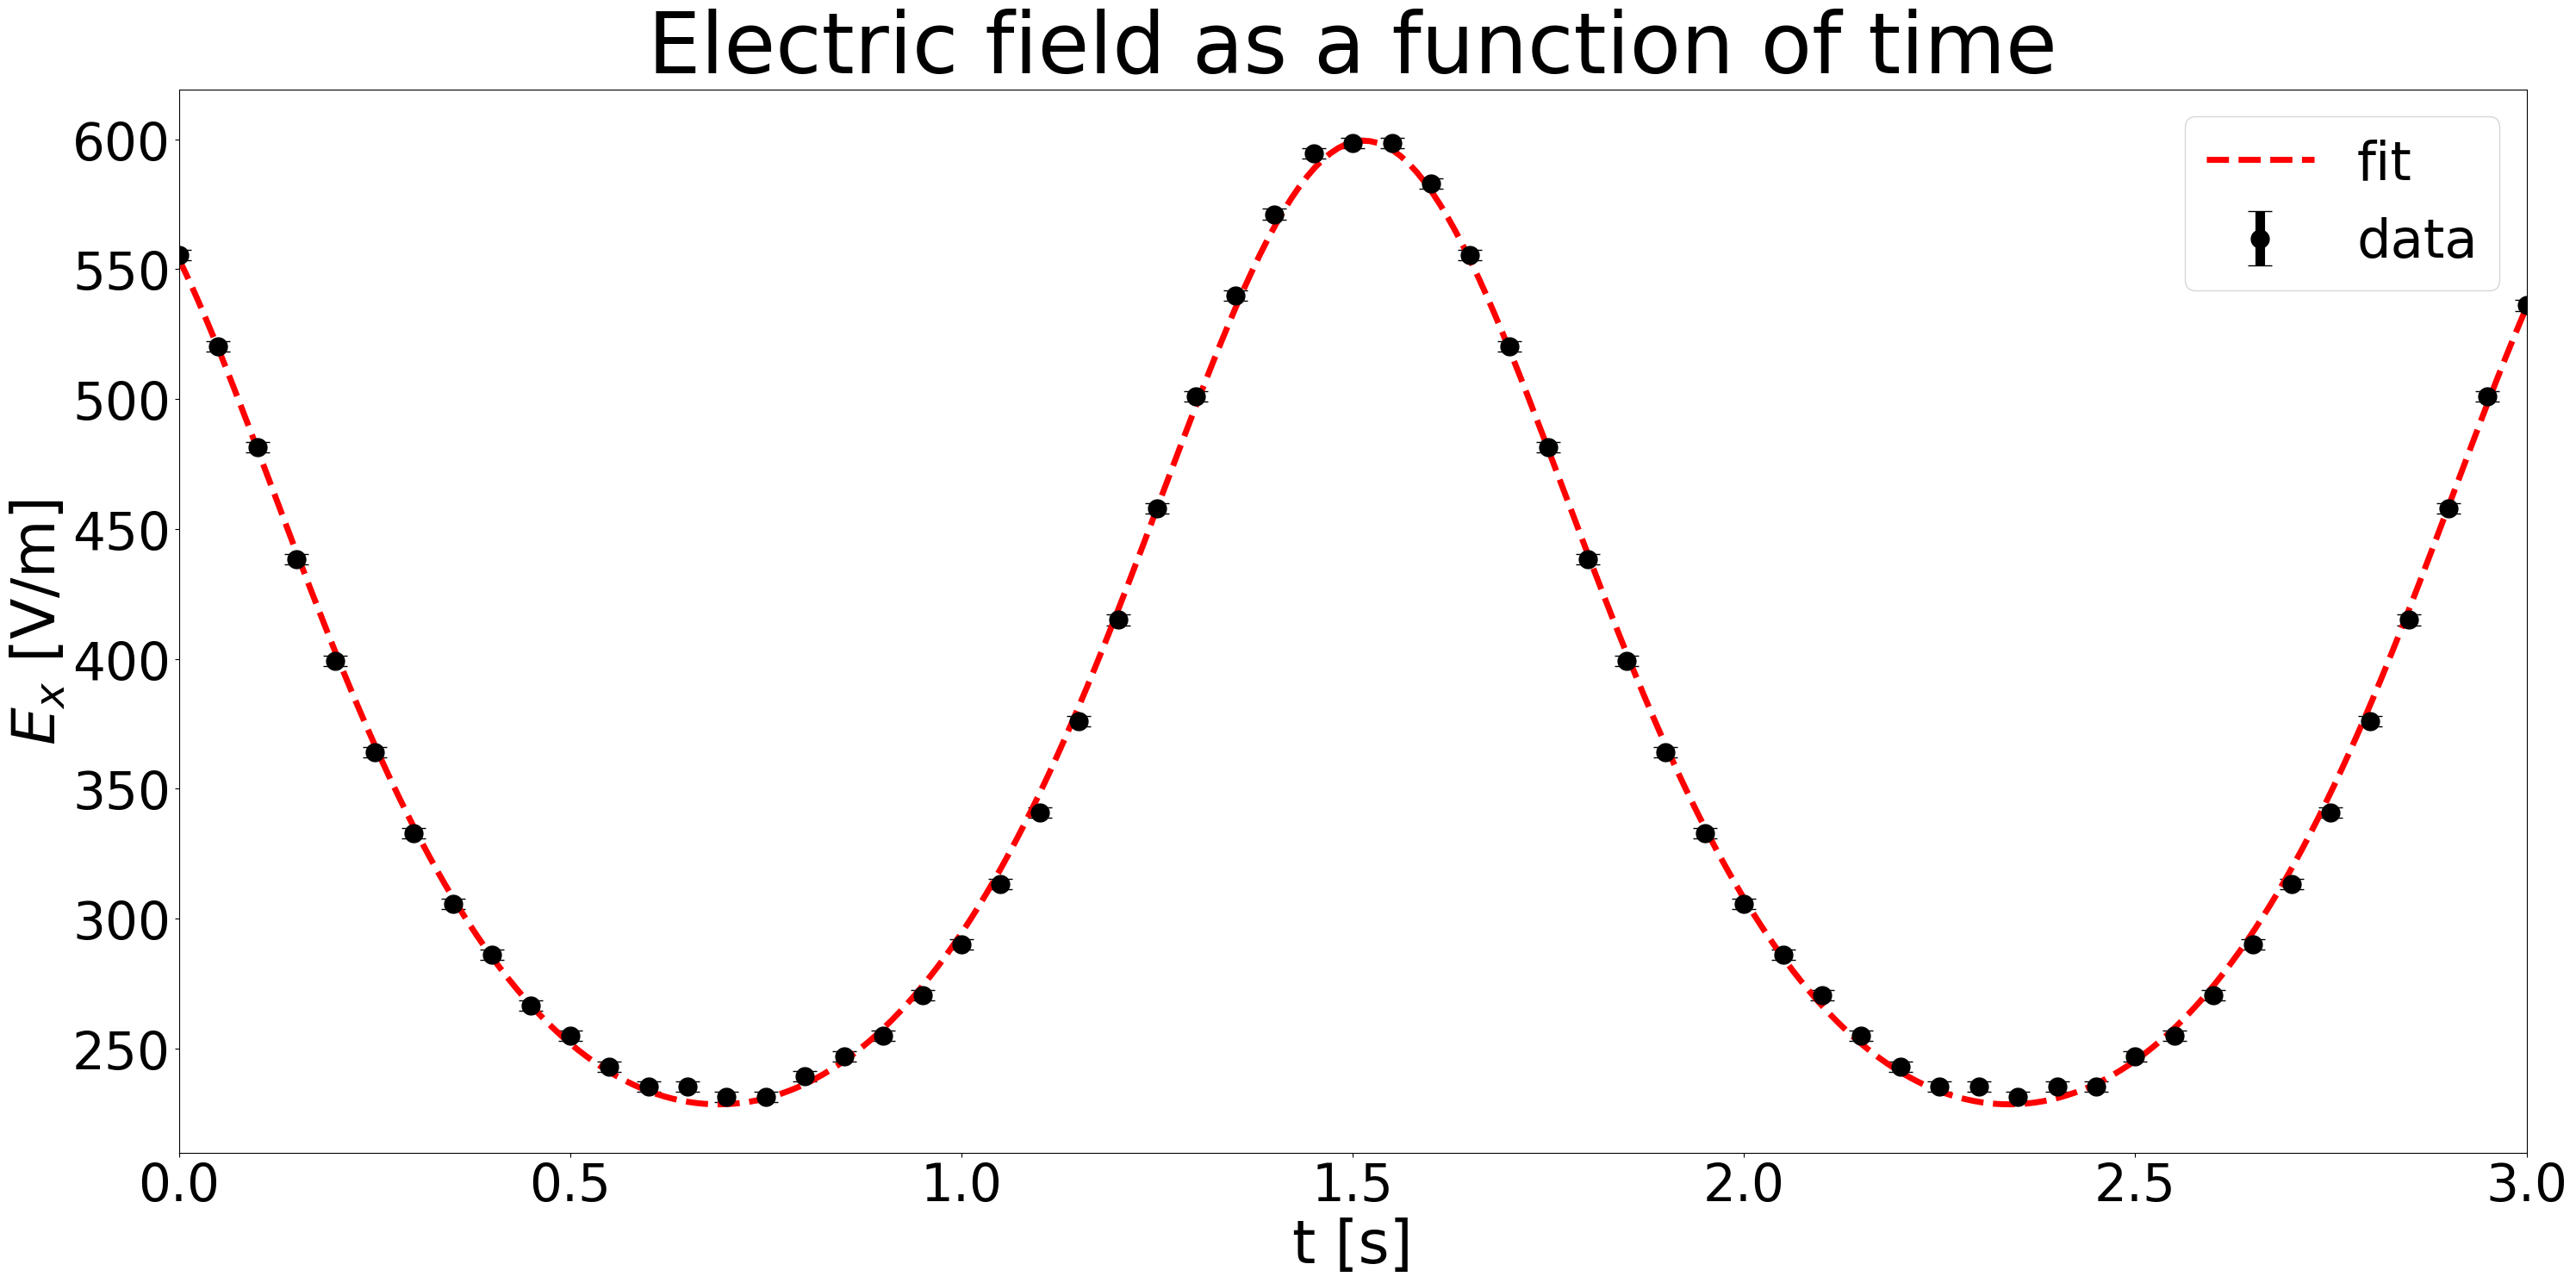

4074

3.8553386833890952 omega_inval
C_0 by fft -815.26171875
1
[1, 0.1521739130434783, -490, 3.8, 2.362948960302458e-08]
beginvwd:  [1, 0.1521739130434783, -490, 3.8, 2.362948960302458e-08]
bounds:  [(-6.283185307179586, 6.283185307179586), (0, 2), (None, None), (2.891504012541821, 4.819173354236369), (1e-10, 0.01)]
[[-0.04995407376564824, -0.057786648597504486], [-0.20644880450263448, -0.20772541393953198], [-489.2209034563707, -489.90442074895634], [3.8193308107912816, 5.632225847395174], [2.609282449768187e-05, 2.6151807975866972e-05]]
phi heeft als waarde: -0.054588 + -0.0031982 - -0.0046344 met 68% betrouwbaarheidsinterval: [-0.049954, -0.057787] 
A_norm heeft als waarde: -0.20702 + -0.00070254 - -0.00057407 met 68% betrouwbaarheidsinterval: [-0.20645, -0.20773] 
C_0 heeft als waarde: -489.52 + -0.38513 - -0.29838 met 68% betrouwbaarheidsinterval: [-489.22, -489.9] 
omega heeft als waarde: 3.8173 + 1.8149 - -0.0020236 met 68% betrouwbaarheidsinterval: [3.8193, 5.6322] 
q_norm heeft als

c:\Users\samfa\anaconda3\Lib\site-packages\scipy\optimize\_minimize.py:580: RuntimeWarning: Method BFGS cannot handle bounds.
  warn('Method %s cannot handle bounds.' % method,
c:\Users\samfa\anaconda3\Lib\site-packages\scipy\optimize\_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


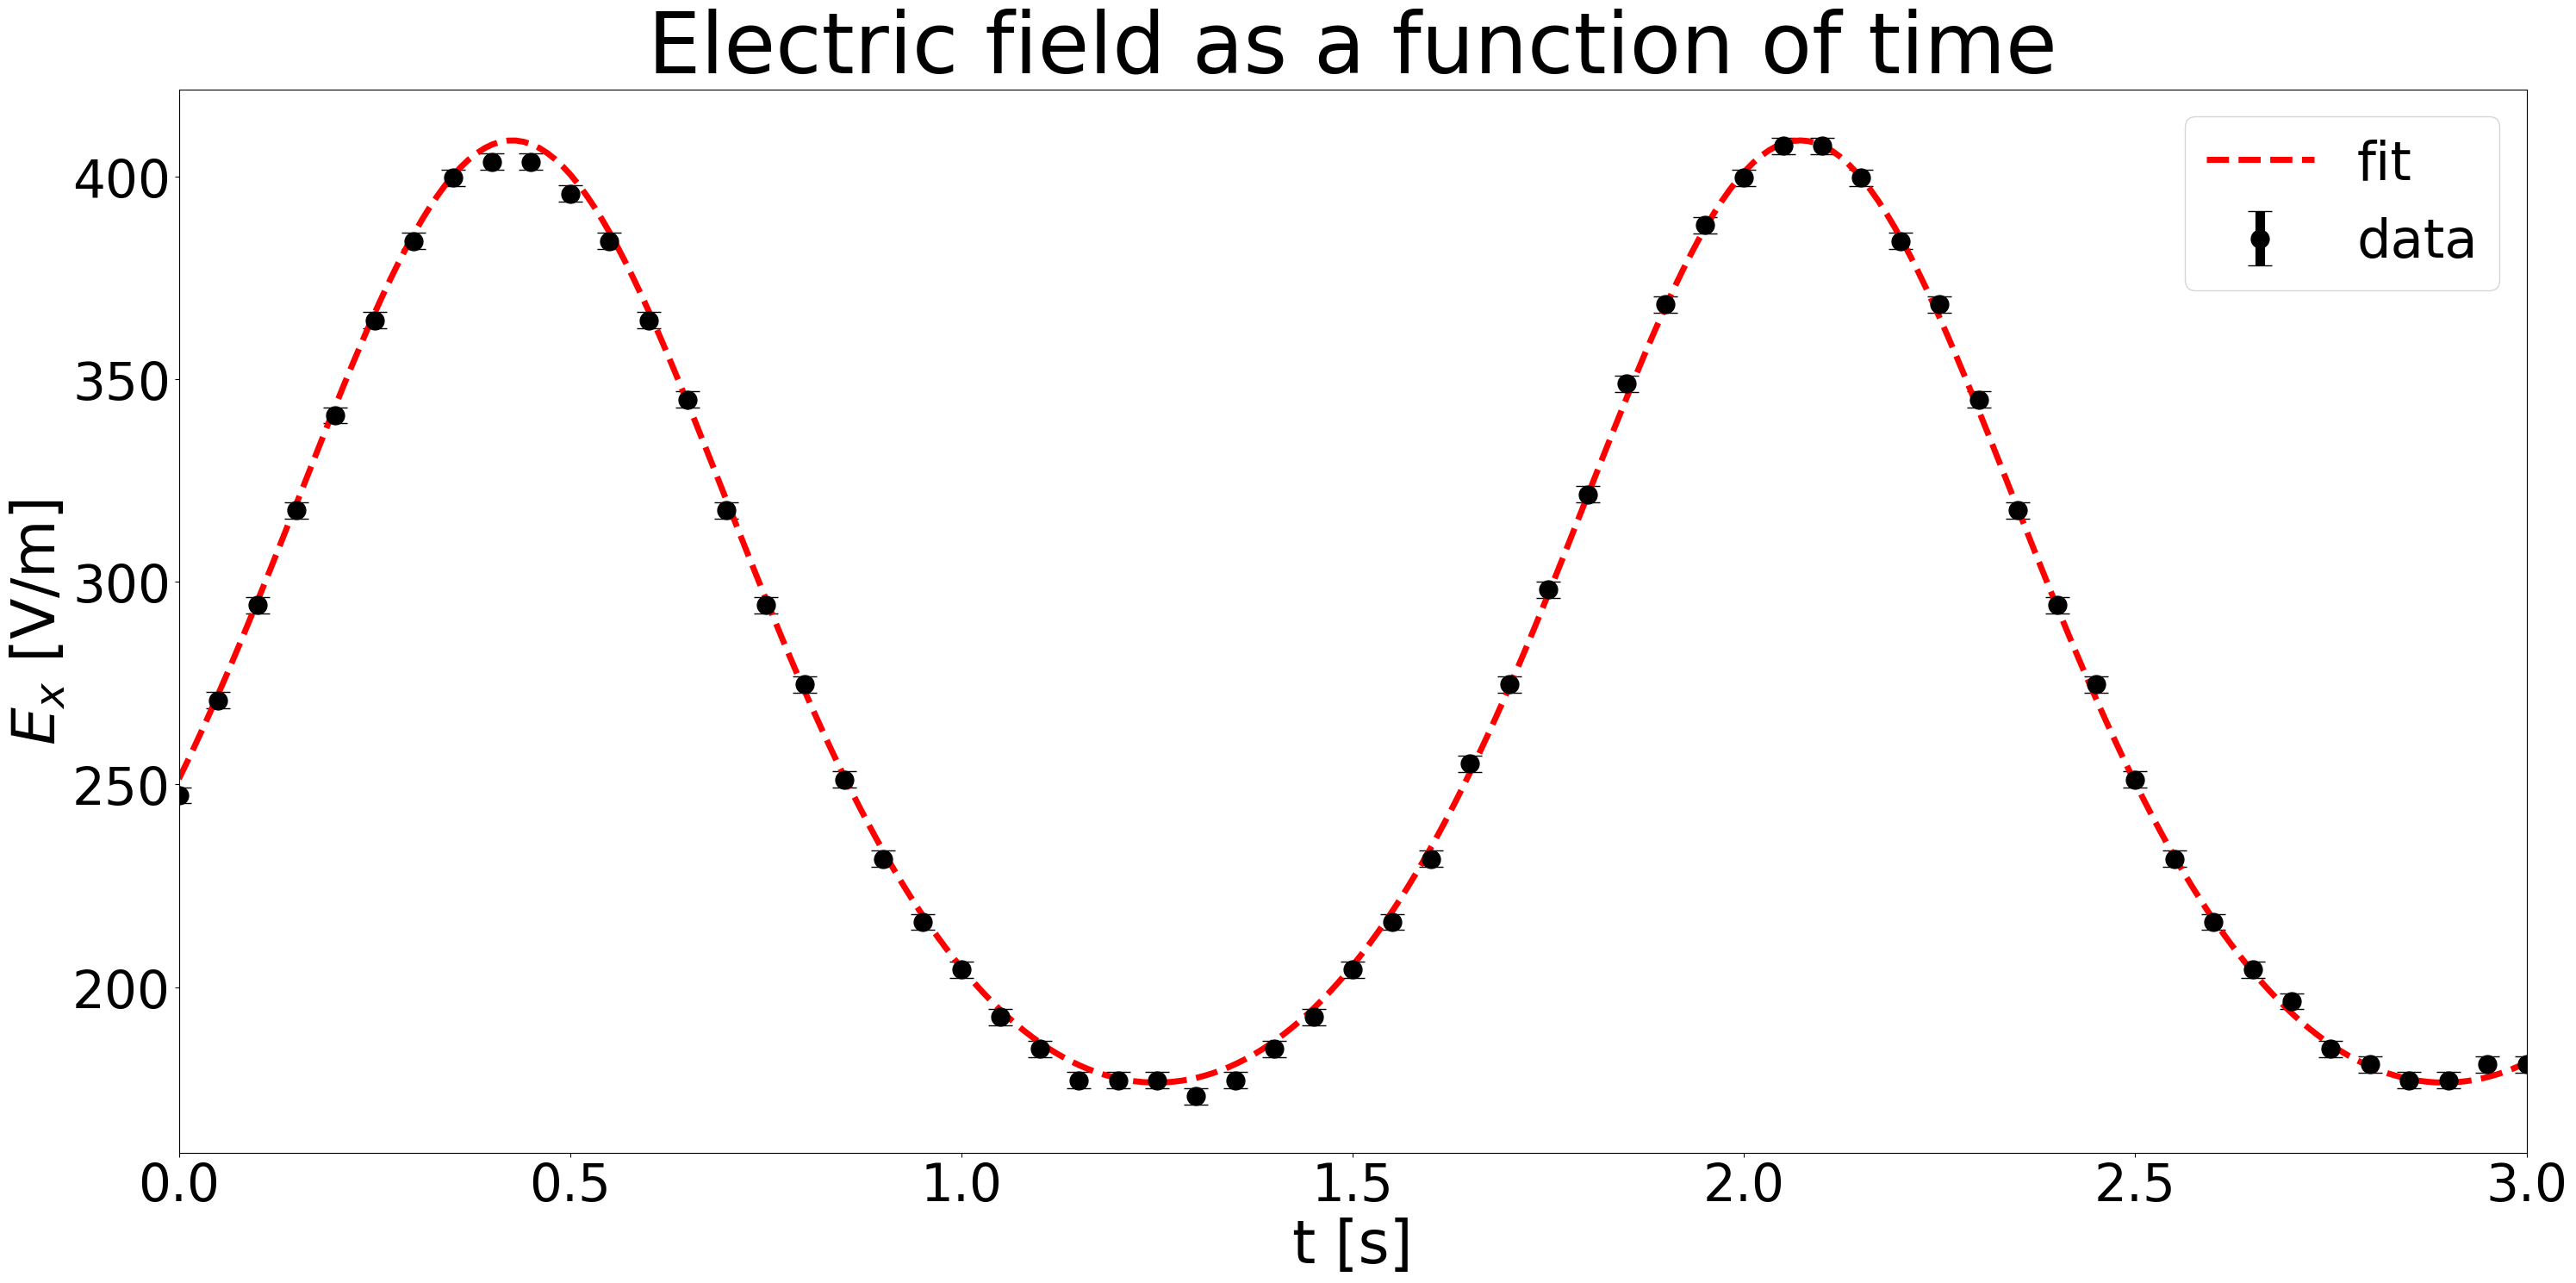

4074

3.8553386833890952 omega_inval
C_0 by fft -534.5859375
1
[-1.3, 0.32608695652173914, -300, 3.8553386833890952, 2.362948960302458e-08]
beginvwd:  [-1.3, 0.32608695652173914, -300, 3.8553386833890952, 2.362948960302458e-08]
bounds:  [(-6.283185307179586, 6.283185307179586), (0, 2), (None, None), (2.891504012541821, 4.819173354236369), (1e-10, 0.01)]
[[-3.190312684301594, -3.2032455689757016], [0.12153755273133784, 0.12248126585435902], [-584.4640187572533, -585.786728708964], [3.818017873901476, 5.637043046840628], [4.3565056364010885e-05, 4.3691220601847715e-05]]
phi heeft als waarde: -3.1919 + -0.011329 - -0.0016042 met 68% betrouwbaarheidsinterval: [-3.1903, -3.2032] 
A_norm heeft als waarde: 0.12201 + 0.00047498 - 0.00046873 met 68% betrouwbaarheidsinterval: [0.12154, 0.12248] 
C_0 heeft als waarde: -584.56 + -1.2292 - -0.093488 met 68% betrouwbaarheidsinterval: [-584.46, -585.79] 
omega heeft als waarde: 3.817 + 1.8201 - -0.0010368 met 68% betrouwbaarheidsinterval: [3.818, 5.637] 
q

c:\Users\samfa\anaconda3\Lib\site-packages\scipy\optimize\_minimize.py:580: RuntimeWarning: Method BFGS cannot handle bounds.
  warn('Method %s cannot handle bounds.' % method,
c:\Users\samfa\anaconda3\Lib\site-packages\scipy\optimize\_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


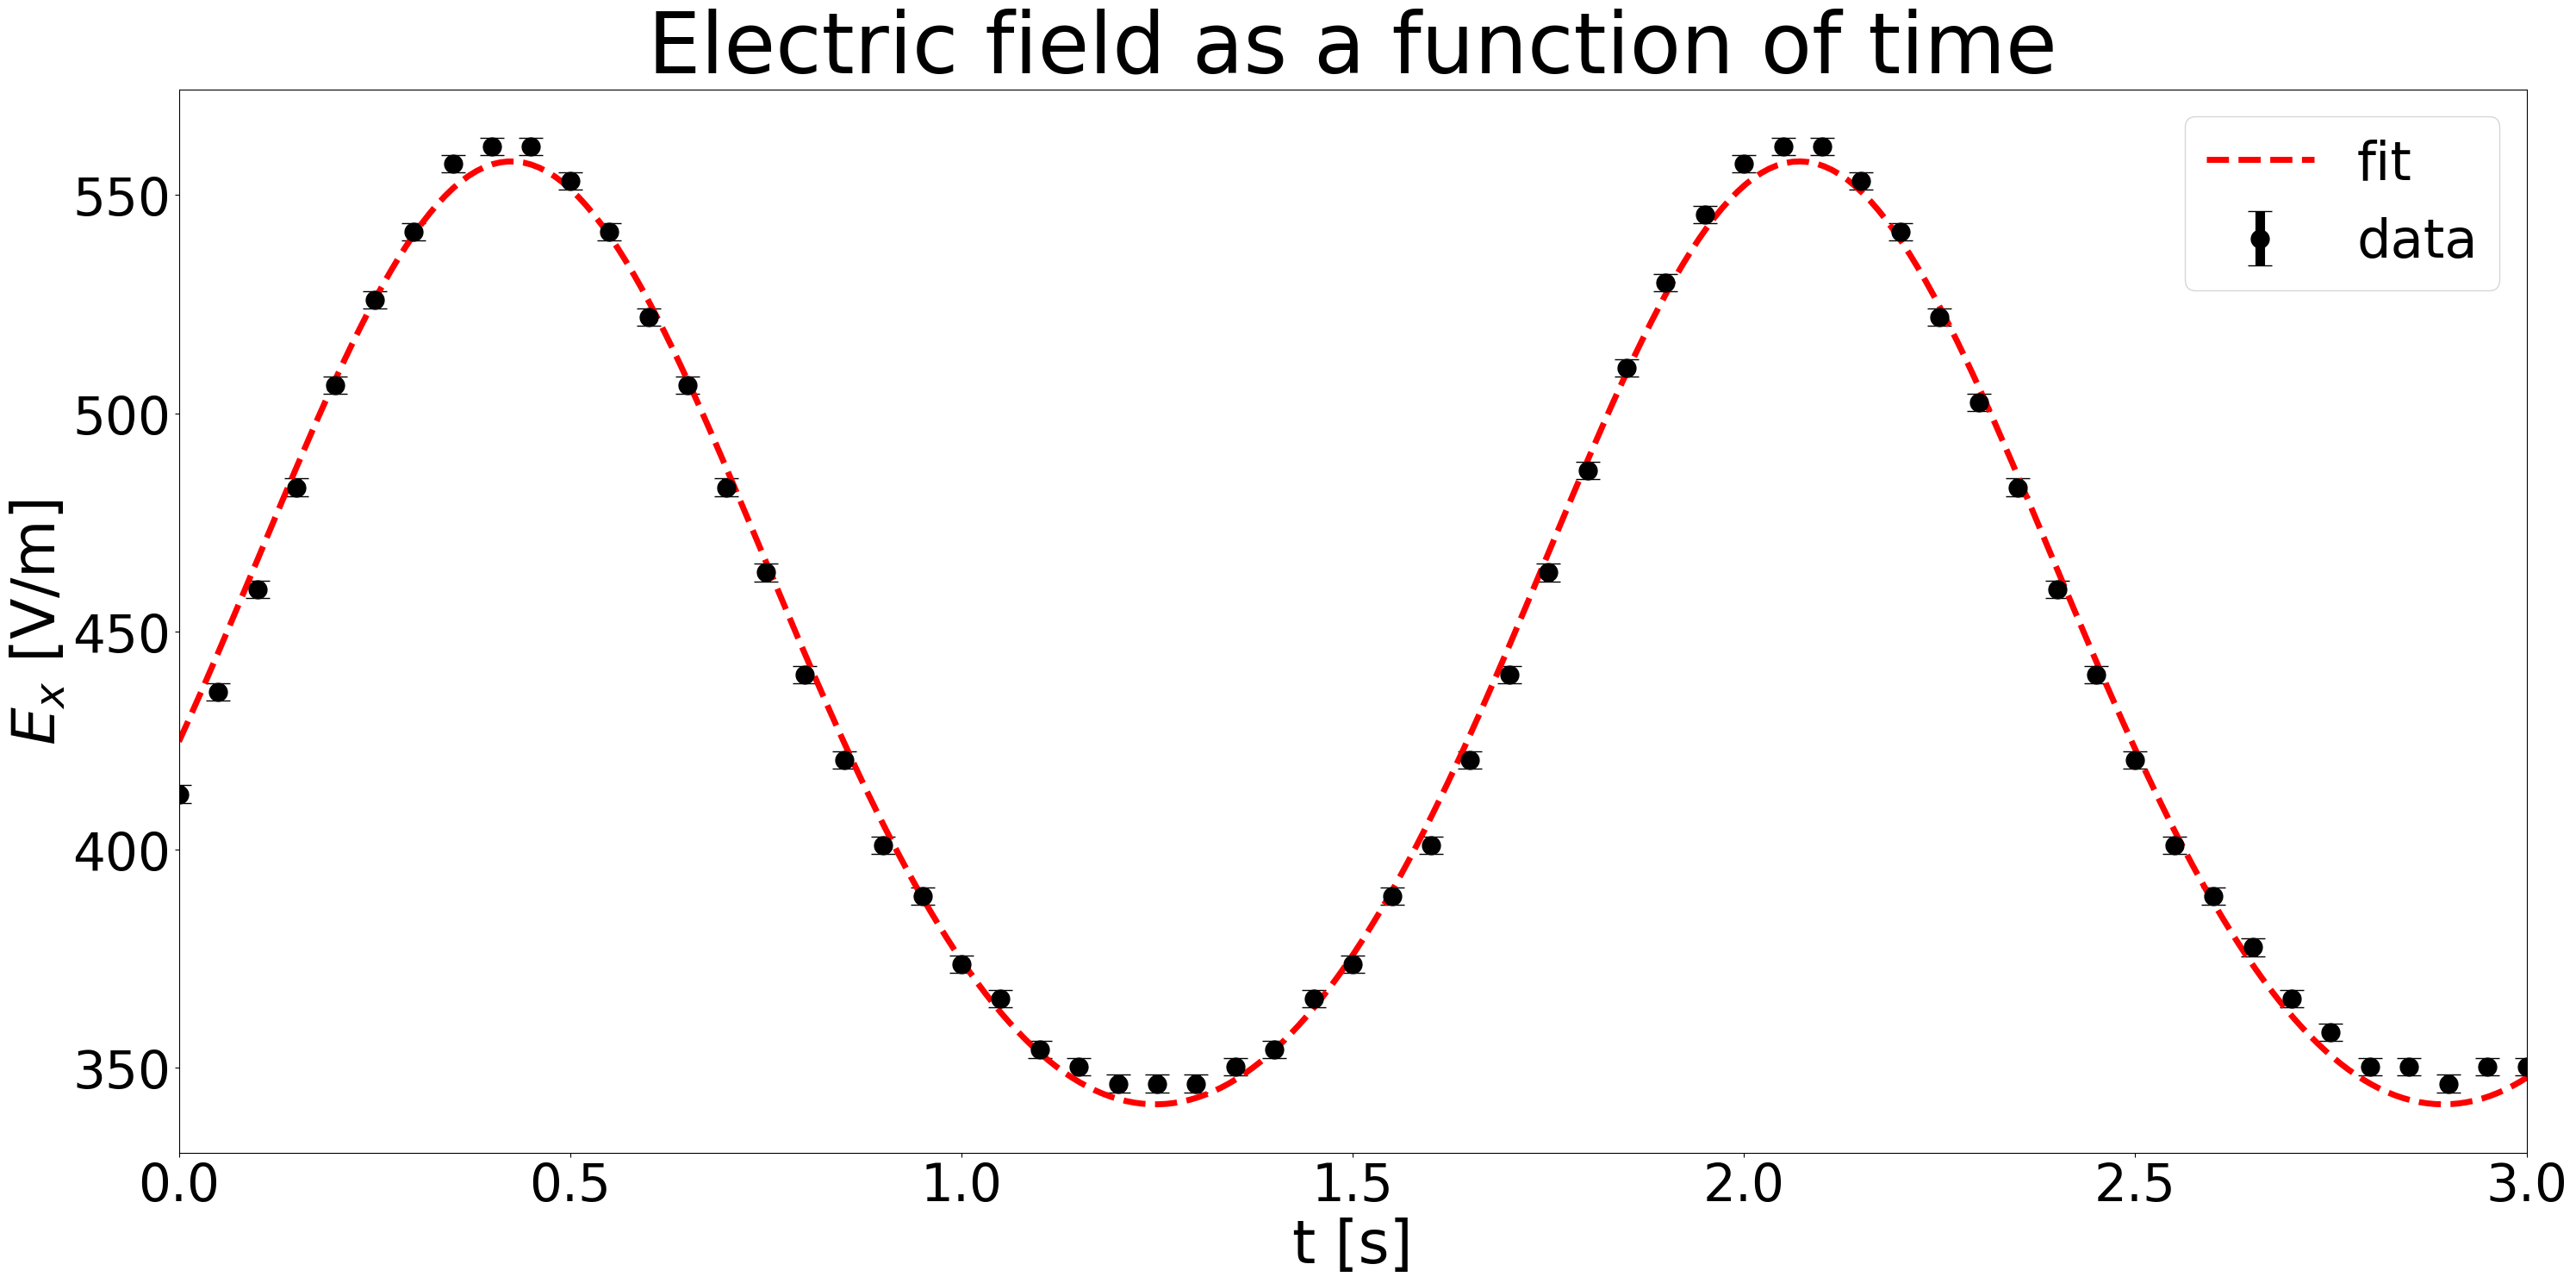

In [22]:
#de data gerecoverd vanuit een louche Githubkelder
# parameters beginvoorwaarden: 'phi', 'A', 'C_0', 'omega', 'q'
#proef 1: OK
analyseer_data('Vrije proef/m1-1.txt', 0.57, 0.66, 5e-9, periodamount=2.5,  beginvoorwaarden = [0, 0.07, -490, 3.8, 2.5e-9], 
               detailed_logs=False, minimizemethod = 'TNC', titel = 'Electric field as a function of time')
analyseer_data('Vrije proef/m1-2.txt', 0.57, 0.66, 5e-9, beginvoorwaarden = [1, 0.07, -490, 3.8, 5e-9], periodamount=2.5, detailed_logs=False, minimizemethod='BFGS', titel = 'Electric field as a function of time')
analyseer_data('Vrije proef/m1-3.txt', 0.57, 0.66, 5e-9, detailed_logs=False, periodamount=2.5, minimizemethod='BFGS')

3259

3.8553386833890952 omega_inval
C_0 by fft 95.37109375003183
1
[-1.3, 0.32608695652173914, -300, 3.8553386833890952, 1.4177693761814749e-08]
beginvwd:  [-1.3, 0.32608695652173914, -300, 3.8553386833890952, 1.4177693761814749e-08]
bounds:  [(-6.283185307179586, 6.283185307179586), (0, 2), (None, None), (2.891504012541821, 4.819173354236369), (1e-10, 0.01)]


c:\Users\samfa\anaconda3\Lib\site-packages\scipy\optimize\_minimize.py:580: RuntimeWarning: Method BFGS cannot handle bounds.
  warn('Method %s cannot handle bounds.' % method,
c:\Users\samfa\anaconda3\Lib\site-packages\scipy\optimize\_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


[[0.0647799945307787, 0.07328463333192968], [0.28080300692297117, 0.28298366302762423], [-208.38308158085727, -209.14330479071117], [0.757768759018657, 6.465432813023865], [2.1190734287480485e-05, 2.1261546635769502e-05]]
phi heeft als waarde: 0.07119 + 0.0020951 - 0.0064095 met 68% betrouwbaarheidsinterval: [0.06478, 0.073285] 
A_norm heeft als waarde: 0.2811 + 0.0018821 - 0.00029852 met 68% betrouwbaarheidsinterval: [0.2808, 0.28298] 
C_0 heeft als waarde: -208.74 + -0.40583 - -0.35439 met 68% betrouwbaarheidsinterval: [-208.38, -209.14] 
omega heeft als waarde: 3.8056 + 2.6598 - 3.0479 met 68% betrouwbaarheidsinterval: [0.75777, 6.4654] 
q_norm heeft als waarde: 2.121e-05 + 5.1776e-08 - 1.9036e-08 met 68% betrouwbaarheidsinterval: [2.1191e-05, 2.1262e-05] 
De p-waarde voor de hypothese test dat het model zinvol is, wordt gegeven door: 1.6753e-26
De gereduceerde chi^2 waarde is: 2.6974
######################### Real data incoming ##############################
datapunt: phi = [0.0711

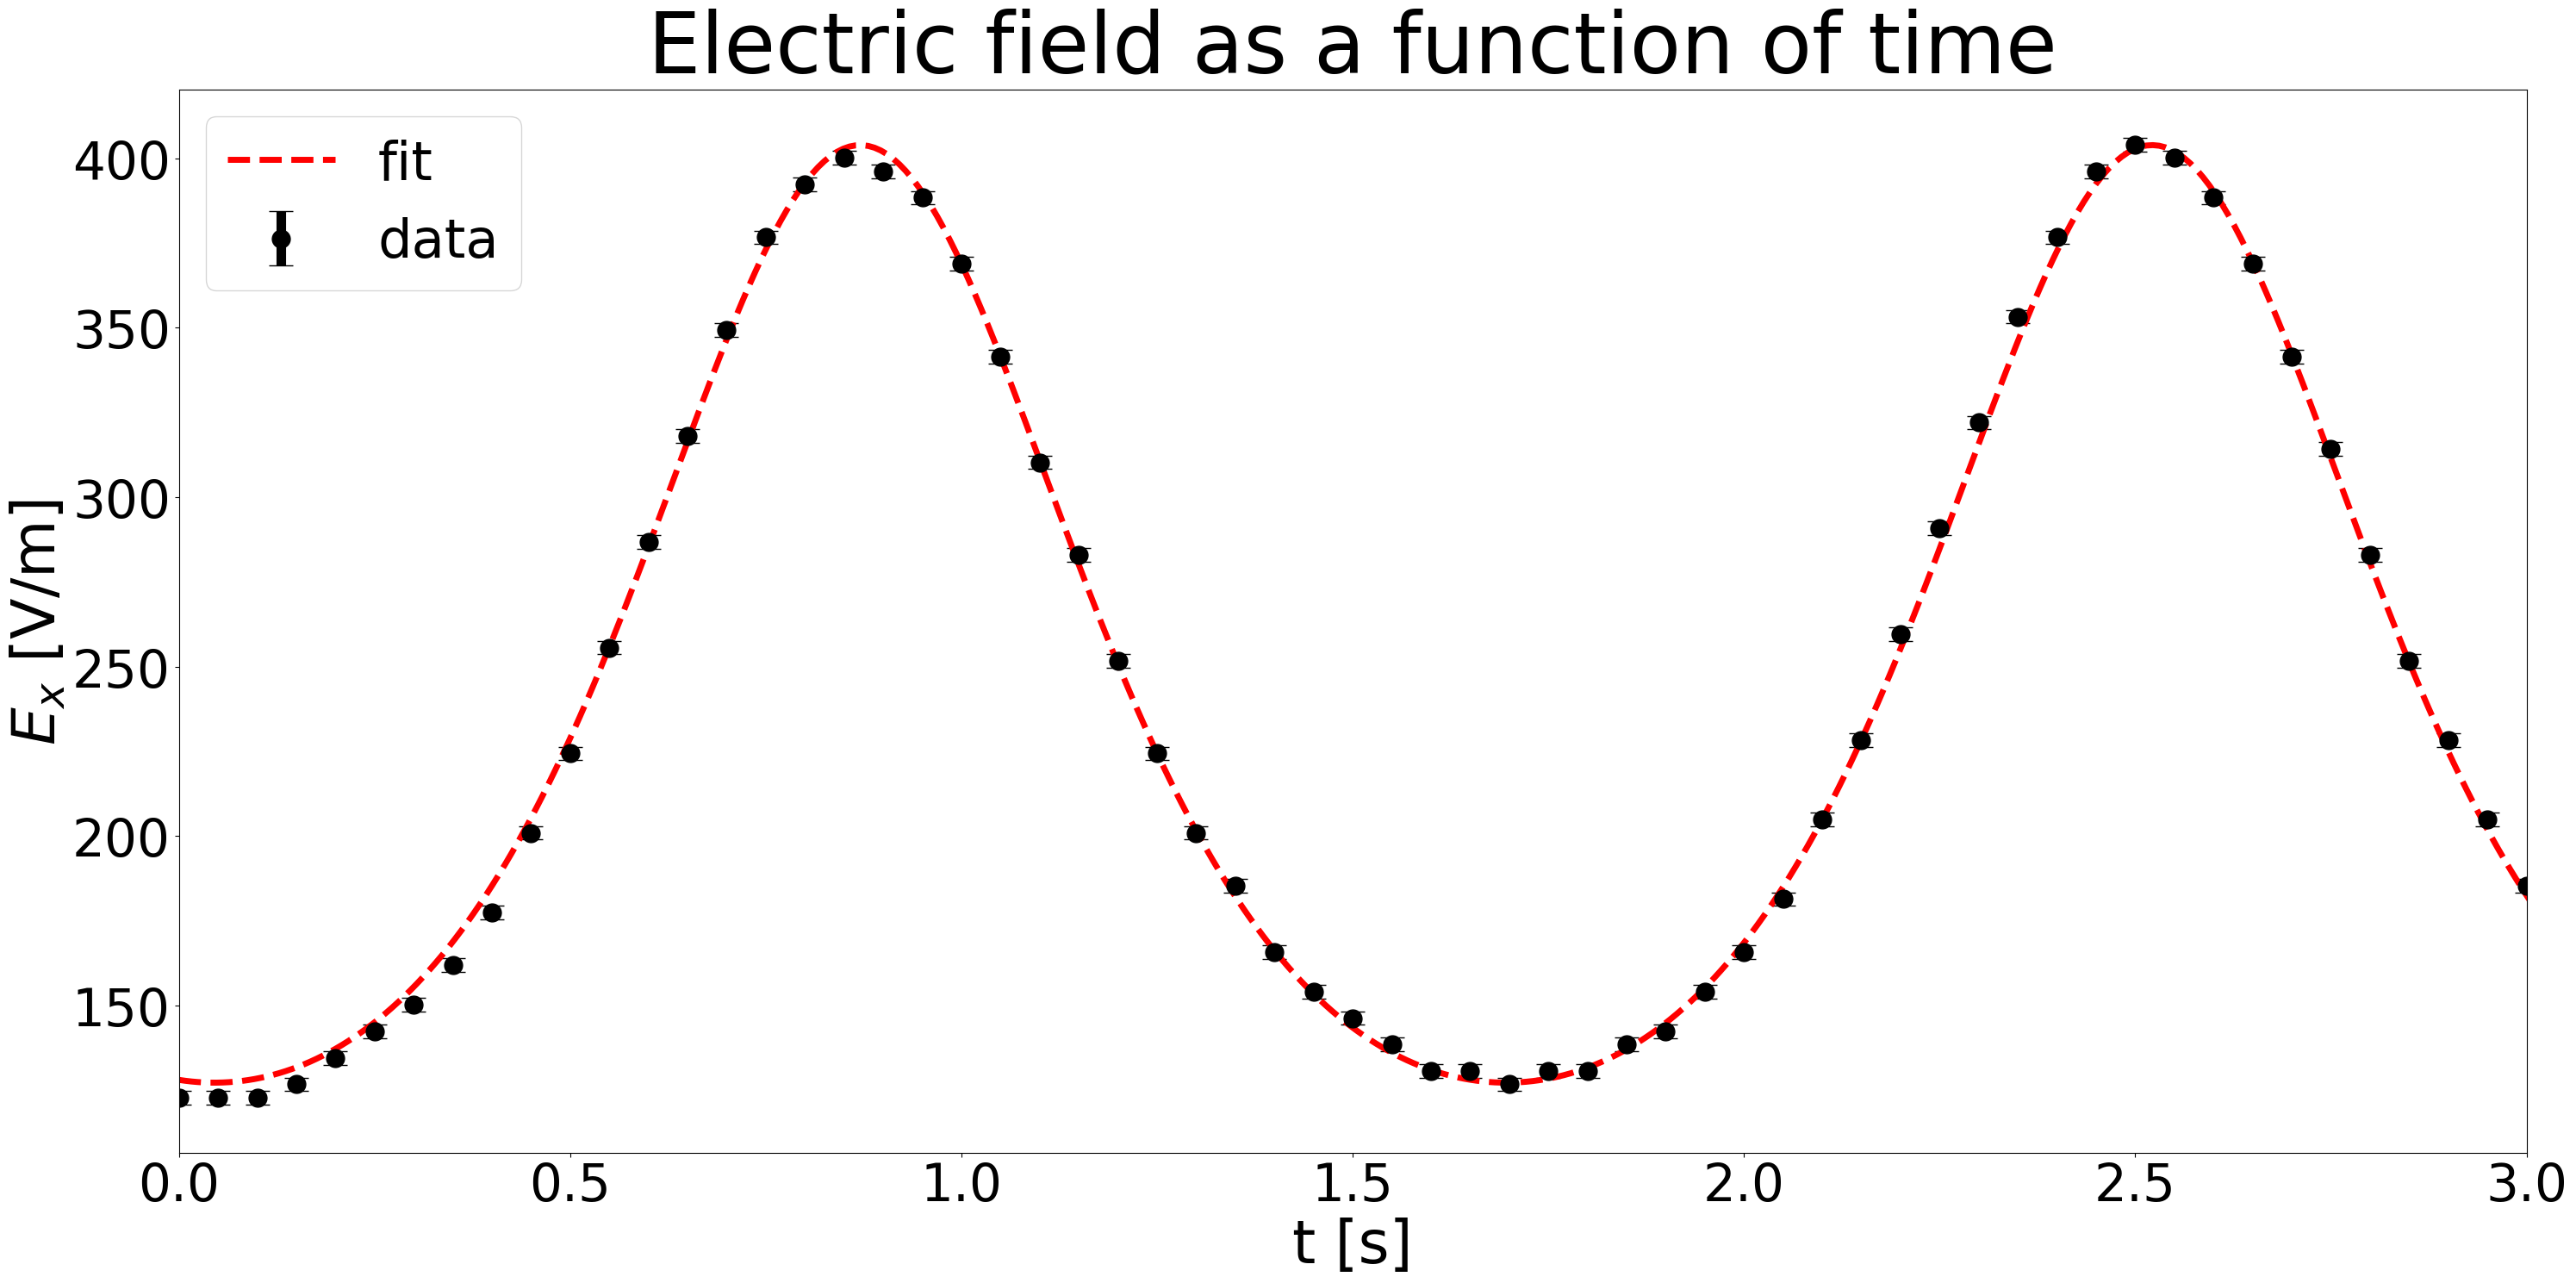

3259

3.8553386833890952 omega_inval
C_0 by fft 259.6406250000867
1
[0, 0.06521739130434782, -400, 3.8, 2.1266540642722122e-08]
beginvwd:  [0, 0.06521739130434782, -400, 3.8, 2.1266540642722122e-08]
bounds:  [(-6.283185307179586, 6.283185307179586), (0, 2), (None, None), (2.891504012541821, 4.819173354236369), (1e-10, 0.01)]
[[0.984446767418331, 0.9904593005269225], [0.3082144649959745, 0.30966556179228133], [-179.68130273259186, -180.51889685502854], [-3.497406423238833, 6.520588087417078], [2.2534590059871733e-05, 2.2594951580925464e-05]]
phi heeft als waarde: 0.98742 + 0.0030394 - 0.0029731 met 68% betrouwbaarheidsinterval: [0.98445, 0.99046] 
A_norm heeft als waarde: 0.3086 + 0.001065 - 0.00038608 met 68% betrouwbaarheidsinterval: [0.30821, 0.30967] 
C_0 heeft als waarde: -179.92 + -0.59647 - -0.24112 met 68% betrouwbaarheidsinterval: [-179.68, -180.52] 
omega heeft als waarde: 3.8123 + 2.7083 - 7.3097 met 68% betrouwbaarheidsinterval: [-3.4974, 6.5206] 
q_norm heeft als waarde: 2.2563e-

c:\Users\samfa\anaconda3\Lib\site-packages\scipy\optimize\_minimize.py:580: RuntimeWarning: Method BFGS cannot handle bounds.
  warn('Method %s cannot handle bounds.' % method,
c:\Users\samfa\anaconda3\Lib\site-packages\scipy\optimize\_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


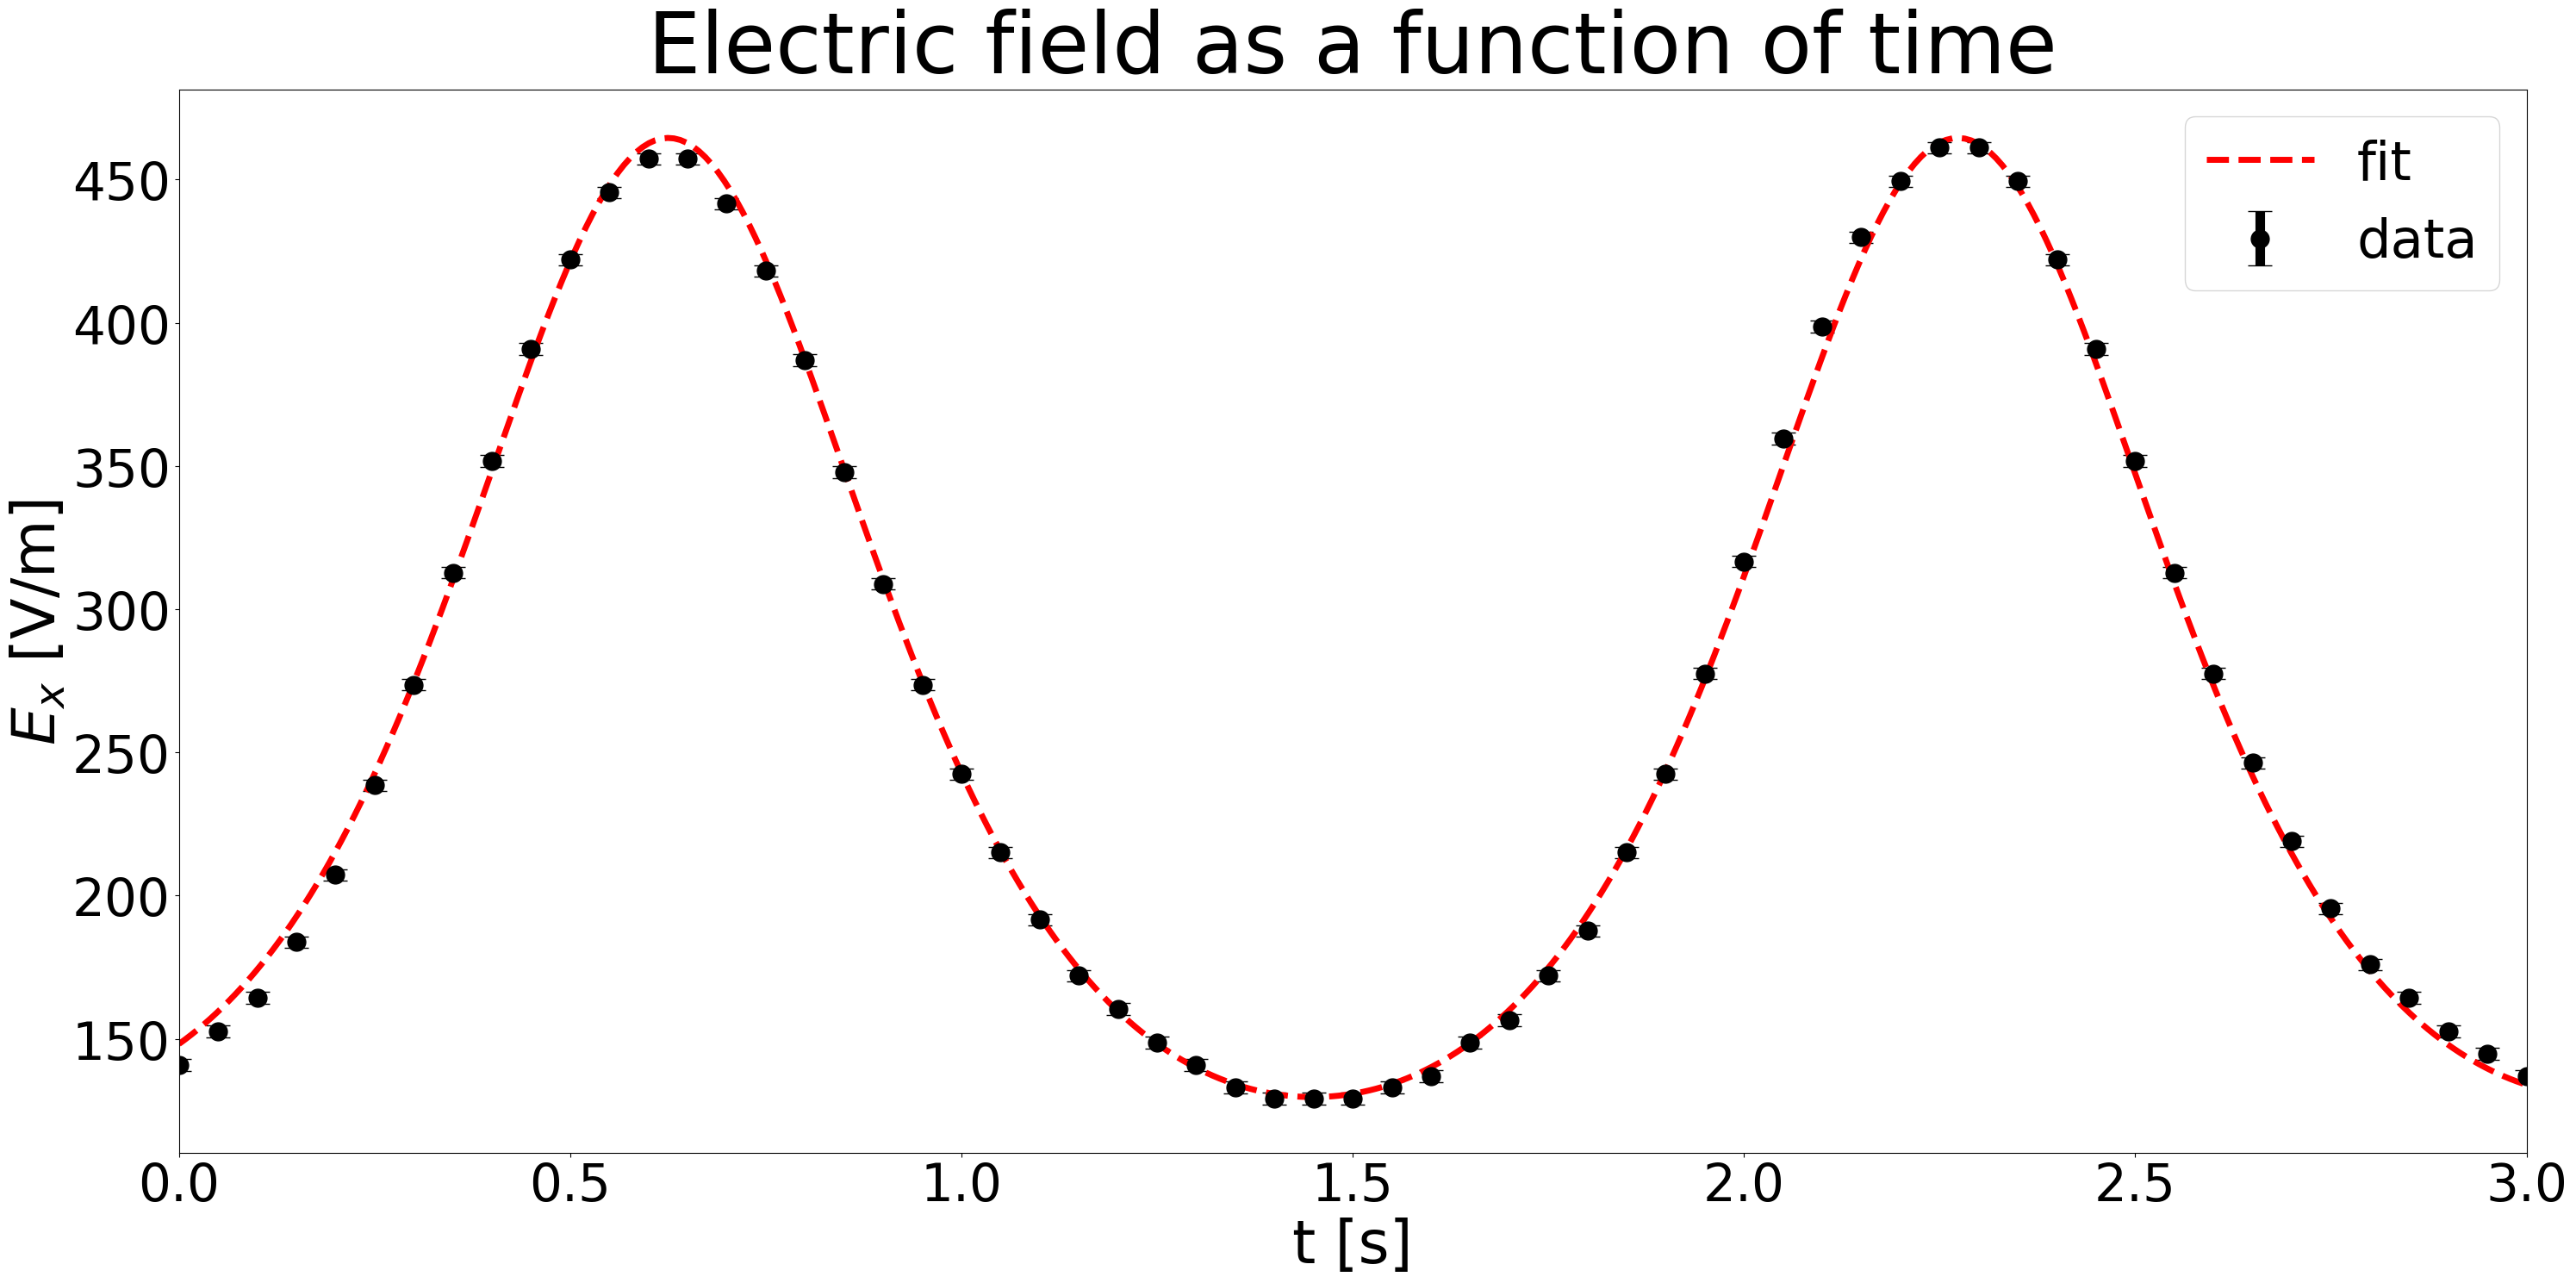

3259

3.8553386833890952 omega_inval
C_0 by fft 72.87499999999999
1
[-1.570795, 0.32608695652173914, -200, 4, 4.725897920604916e-09]
beginvwd:  [-1.570795, 0.32608695652173914, -200, 4, 4.725897920604916e-09]
bounds:  [(-6.283185307179586, 6.283185307179586), (0, 2), (None, None), (2.891504012541821, 4.819173354236369), (1e-10, 0.01)]
[[-2.3714824113154305, -2.39270010428995], [0.11212948189940986, 0.11438294390100734], [-198.41310306410287, -199.17244145715182], [-0.3932834548494142, 7.950163957599805], [2.2010138131377838e-05, 2.208508390962509e-05]]
phi heeft als waarde: -2.382 + -0.010702 - -0.010516 met 68% betrouwbaarheidsinterval: [-2.3715, -2.3927] 
A_norm heeft als waarde: 0.11313 + 0.0012498 - 0.0010037 met 68% betrouwbaarheidsinterval: [0.11213, 0.11438] 
C_0 heeft als waarde: -198.81 + -0.36163 - -0.39771 met 68% betrouwbaarheidsinterval: [-198.41, -199.17] 
omega heeft als waarde: 3.8157 + 4.1345 - 4.2089 met 68% betrouwbaarheidsinterval: [-0.39328, 7.9502] 
q_norm heeft als waa

c:\Users\samfa\anaconda3\Lib\site-packages\scipy\optimize\_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


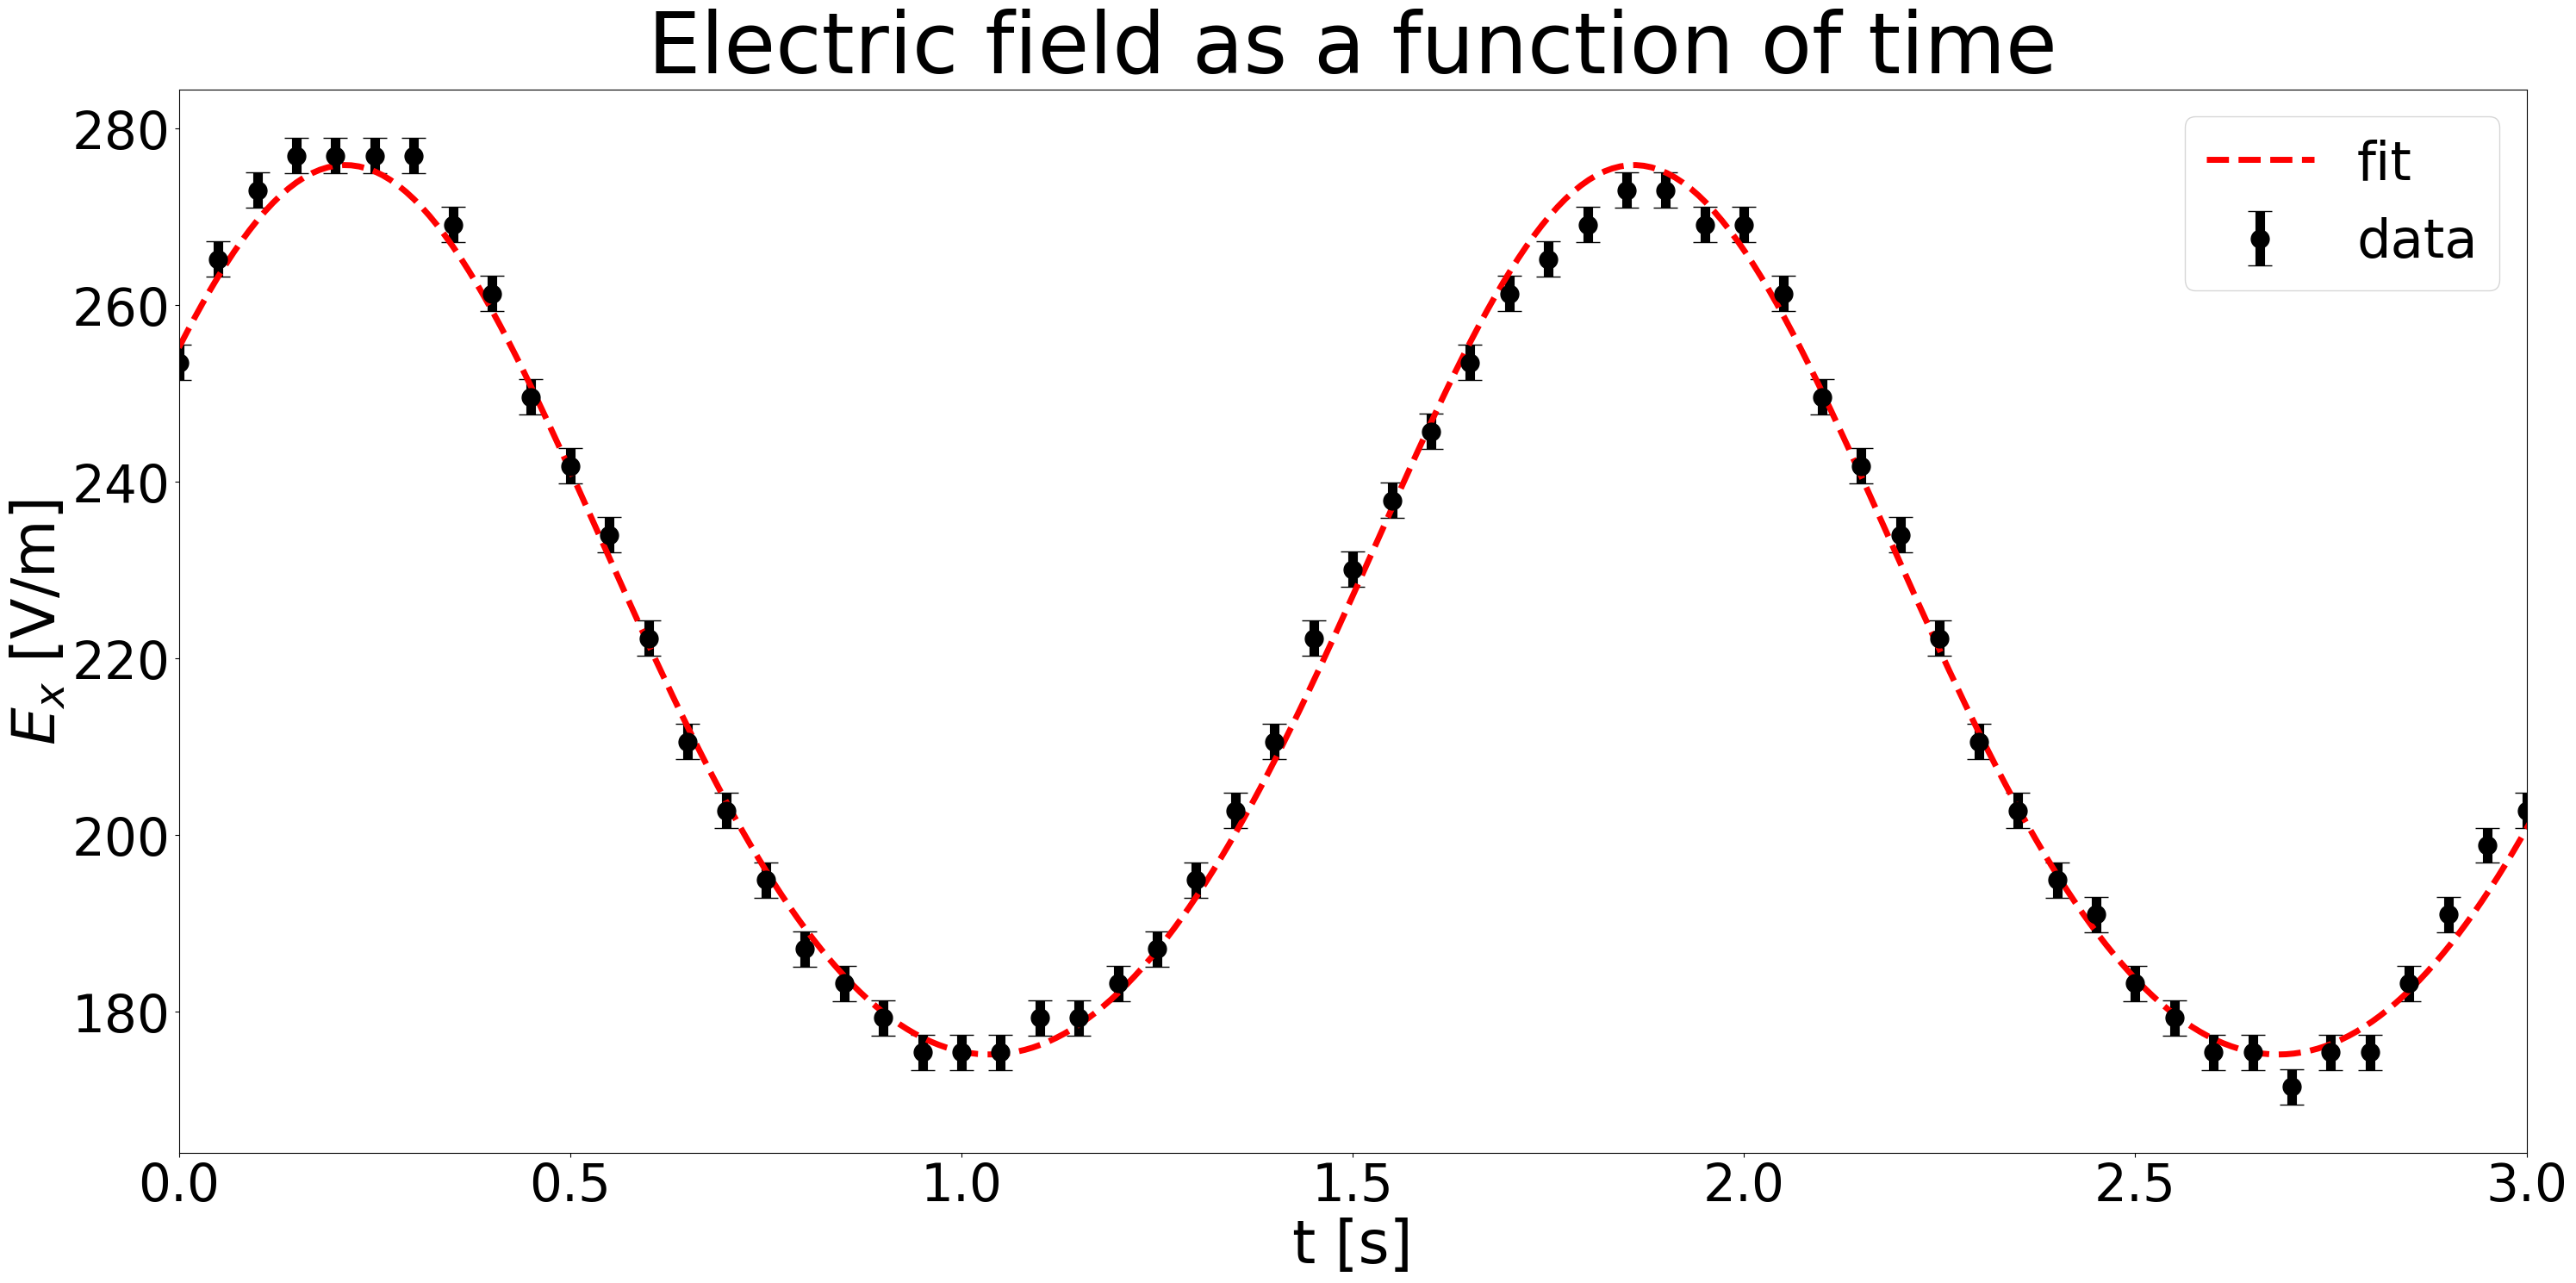

In [23]:
# parameters beginvoorwaarden: 'phi', 'A', 'C_0', 'omega', 'q', 'x0'"
#proef 2: OK
analyseer_data('Vrije proef/m2-1.txt', 0.57, 0.66, 3e-9, knipvanaf = 2, detailed_logs=False, minimizemethod='BFGS') #amplitude doet raar
analyseer_data('Vrije proef/m2-2.txt', 0.57, 0.66, 3e-9, knipvanaf = 2, beginvoorwaarden = [0, 0.03, -400, 3.8, 4.5e-9], detailed_logs=False, minimizemethod='BFGS')
analyseer_data('Vrije proef/m2-3.txt', 0.57, 0.66, 3e-9, beginvoorwaarden = [-3.14159/2, .15, -200, 4, 1e-9], detailed_logs=False, minimizemethod='TNC')

3259

3.8553386833890952 omega_inval
C_0 by fft -424.98828125
1
[0.1, 0.32608695652173914, -490, 4.028, 4.725897920604916e-09]
beginvwd:  [0.1, 0.32608695652173914, -490, 4.028, 4.725897920604916e-09]
bounds:  [(-6.283185307179586, 6.283185307179586), (0, 2), (None, None), (2.891504012541821, 4.819173354236369), (1e-10, 0.01)]
[[1.9907027262094417, 2.0151904679571655], [0.0734628501649233, 0.07525982609370224], [-421.35541092863957, -422.4044739622992], [3.8350698559125656, 6.284709031473287], [2.9237449698519696e-05, 2.9343627888099387e-05]]
phi heeft als waarde: 2.0038 + 0.011403 - 0.013085 met 68% betrouwbaarheidsinterval: [1.9907, 2.0152] 
A_norm heeft als waarde: 0.074278 + 0.00098187 - 0.00081511 met 68% betrouwbaarheidsinterval: [0.073463, 0.07526] 
C_0 heeft als waarde: -421.52 + -0.8869 - -0.16216 met 68% betrouwbaarheidsinterval: [-421.36, -422.4] 
omega heeft als waarde: 3.8413 + 2.4434 - 0.0062419 met 68% betrouwbaarheidsinterval: [3.8351, 6.2847] 
q_norm heeft als waarde: 2.9328

c:\Users\samfa\anaconda3\Lib\site-packages\scipy\optimize\_minimize.py:580: RuntimeWarning: Method BFGS cannot handle bounds.
  warn('Method %s cannot handle bounds.' % method,
c:\Users\samfa\anaconda3\Lib\site-packages\scipy\optimize\_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


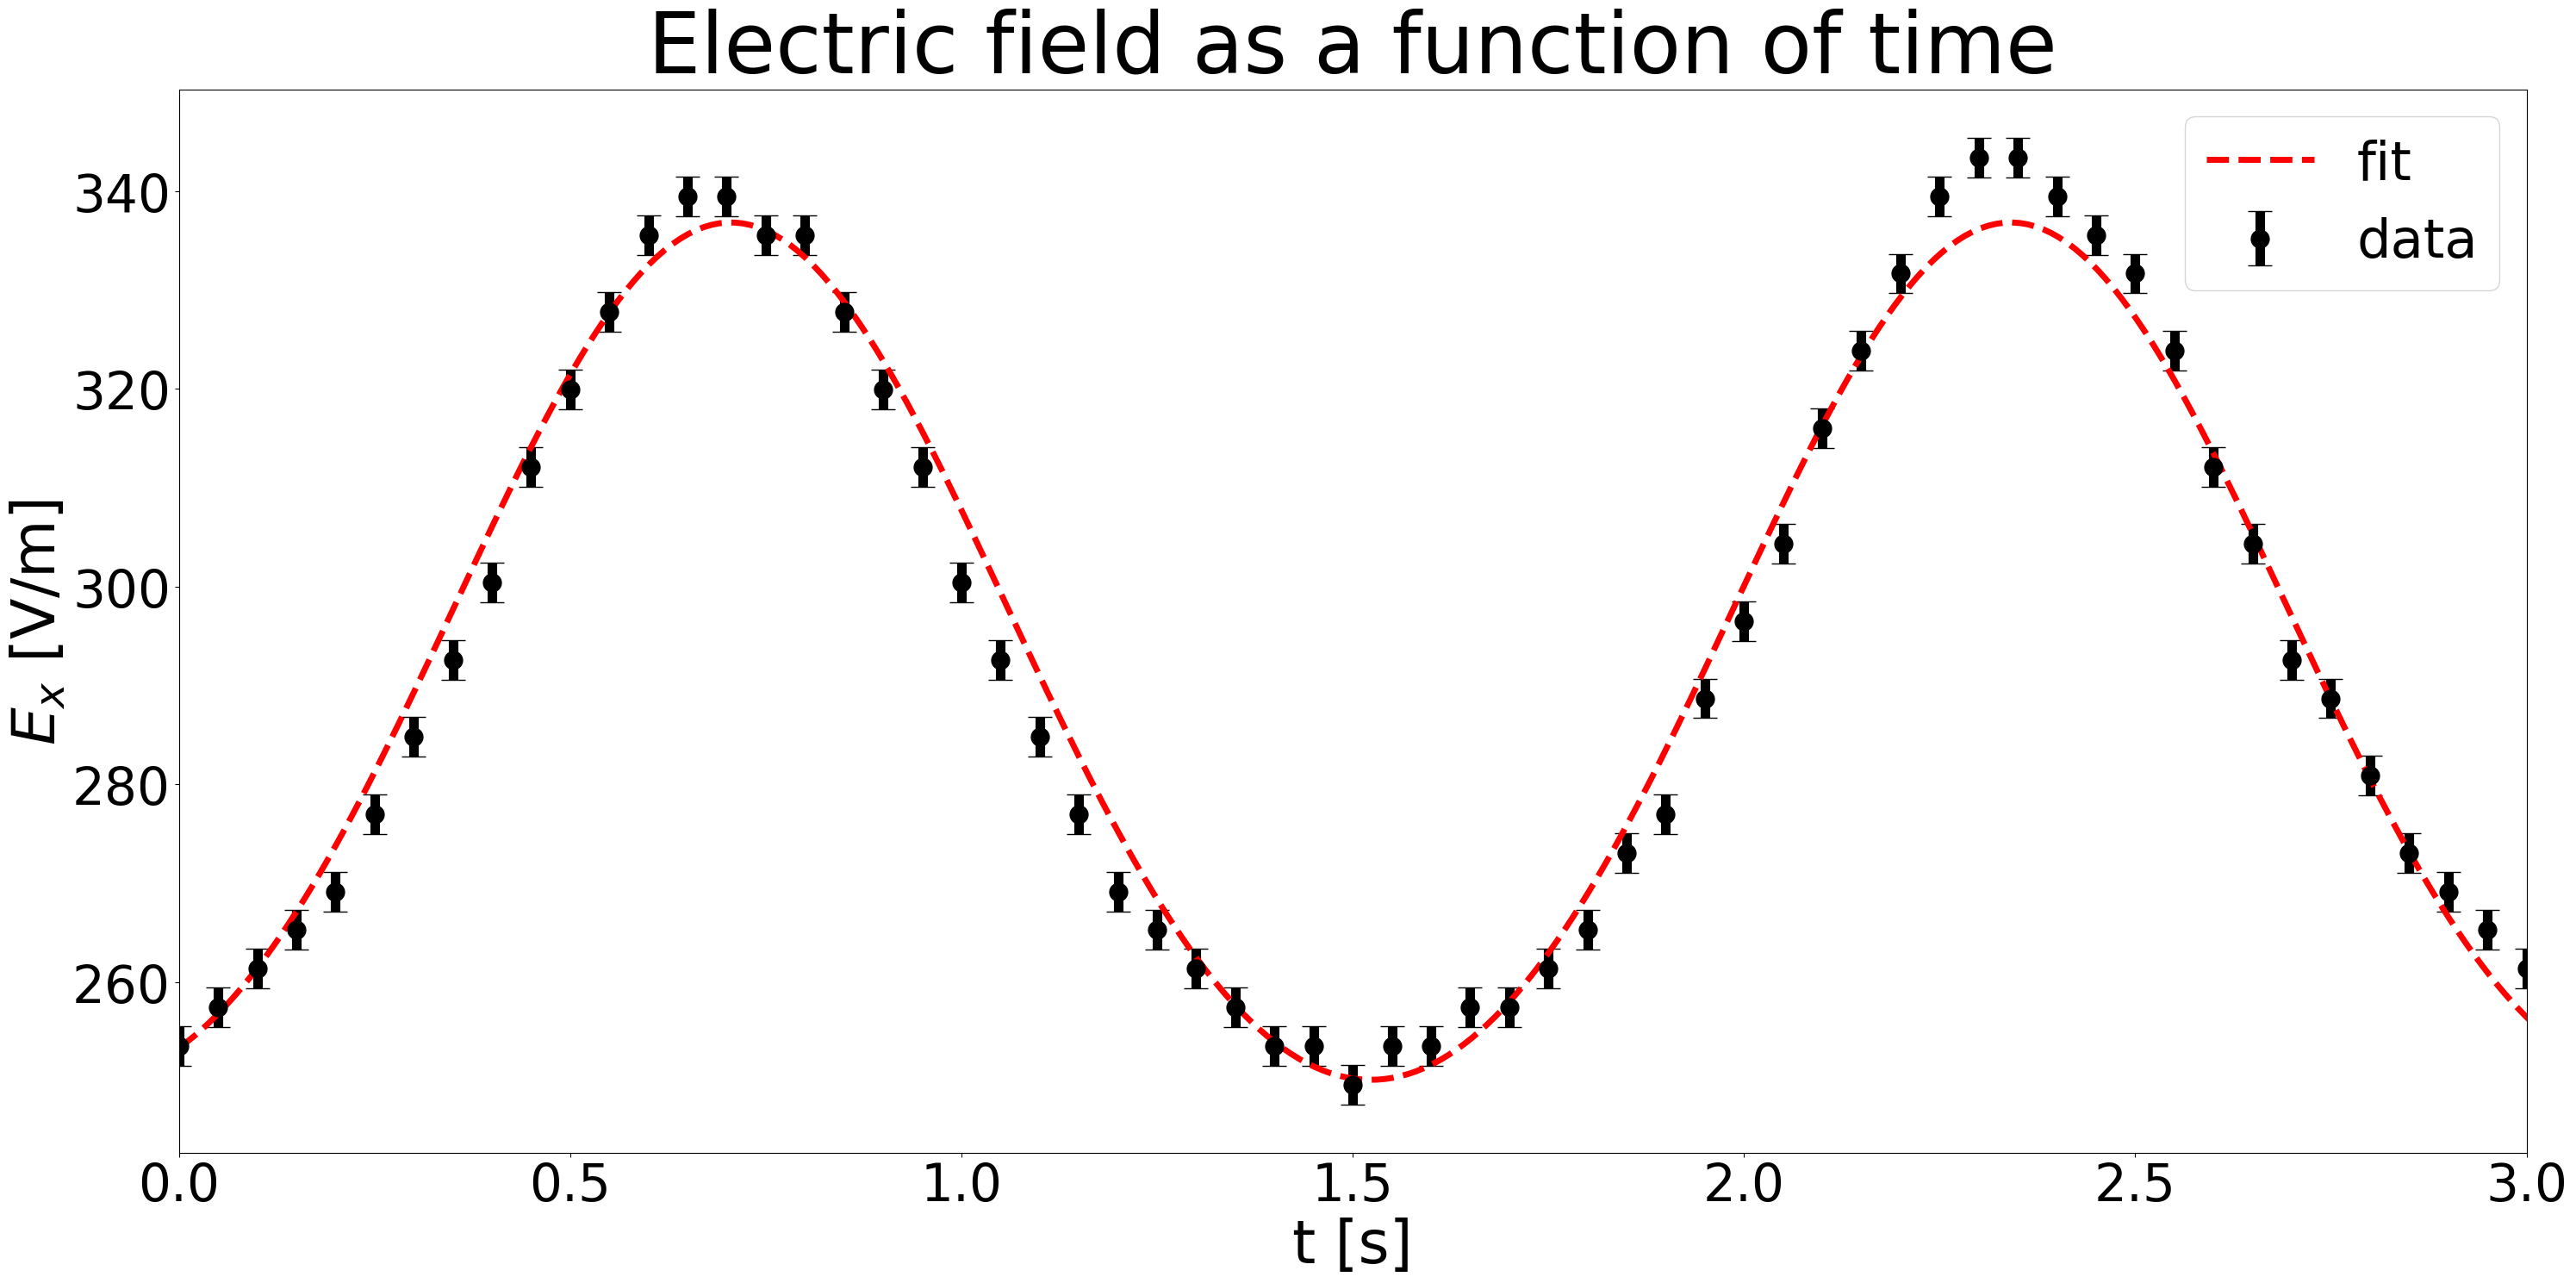

3259

3.8553386833890952 omega_inval
C_0 by fft -408.65234374977354
1
[0.1, 0.32608695652173914, -350, 4, 4.725897920604916e-09]
beginvwd:  [0.1, 0.32608695652173914, -350, 4, 4.725897920604916e-09]
bounds:  [(-6.283185307179586, 6.283185307179586), (0, 2), (None, None), (2.891504012541821, 4.819173354236369), (1e-10, 0.01)]
[[2.069002220002897, 2.085802572899844], [0.14161288029362248, 0.14381932218771076], [-342.12830008662814, -342.9298924762814], [2.9250009296698973, 6.275809679747828], [2.1318630482645097e-05, 2.1392487210841483e-05]]
phi heeft als waarde: 2.0773 + 0.0085417 - 0.0082586 met 68% betrouwbaarheidsinterval: [2.069, 2.0858] 
A_norm heeft als waarde: 0.14268 + 0.0011399 - 0.0010666 met 68% betrouwbaarheidsinterval: [0.14161, 0.14382] 
C_0 heeft als waarde: -342.66 + -0.27113 - -0.53047 met 68% betrouwbaarheidsinterval: [-342.13, -342.93] 
omega heeft als waarde: 3.841 + 2.4348 - 0.91603 met 68% betrouwbaarheidsinterval: [2.925, 6.2758] 
q_norm heeft als waarde: 2.1351e-05 + 4

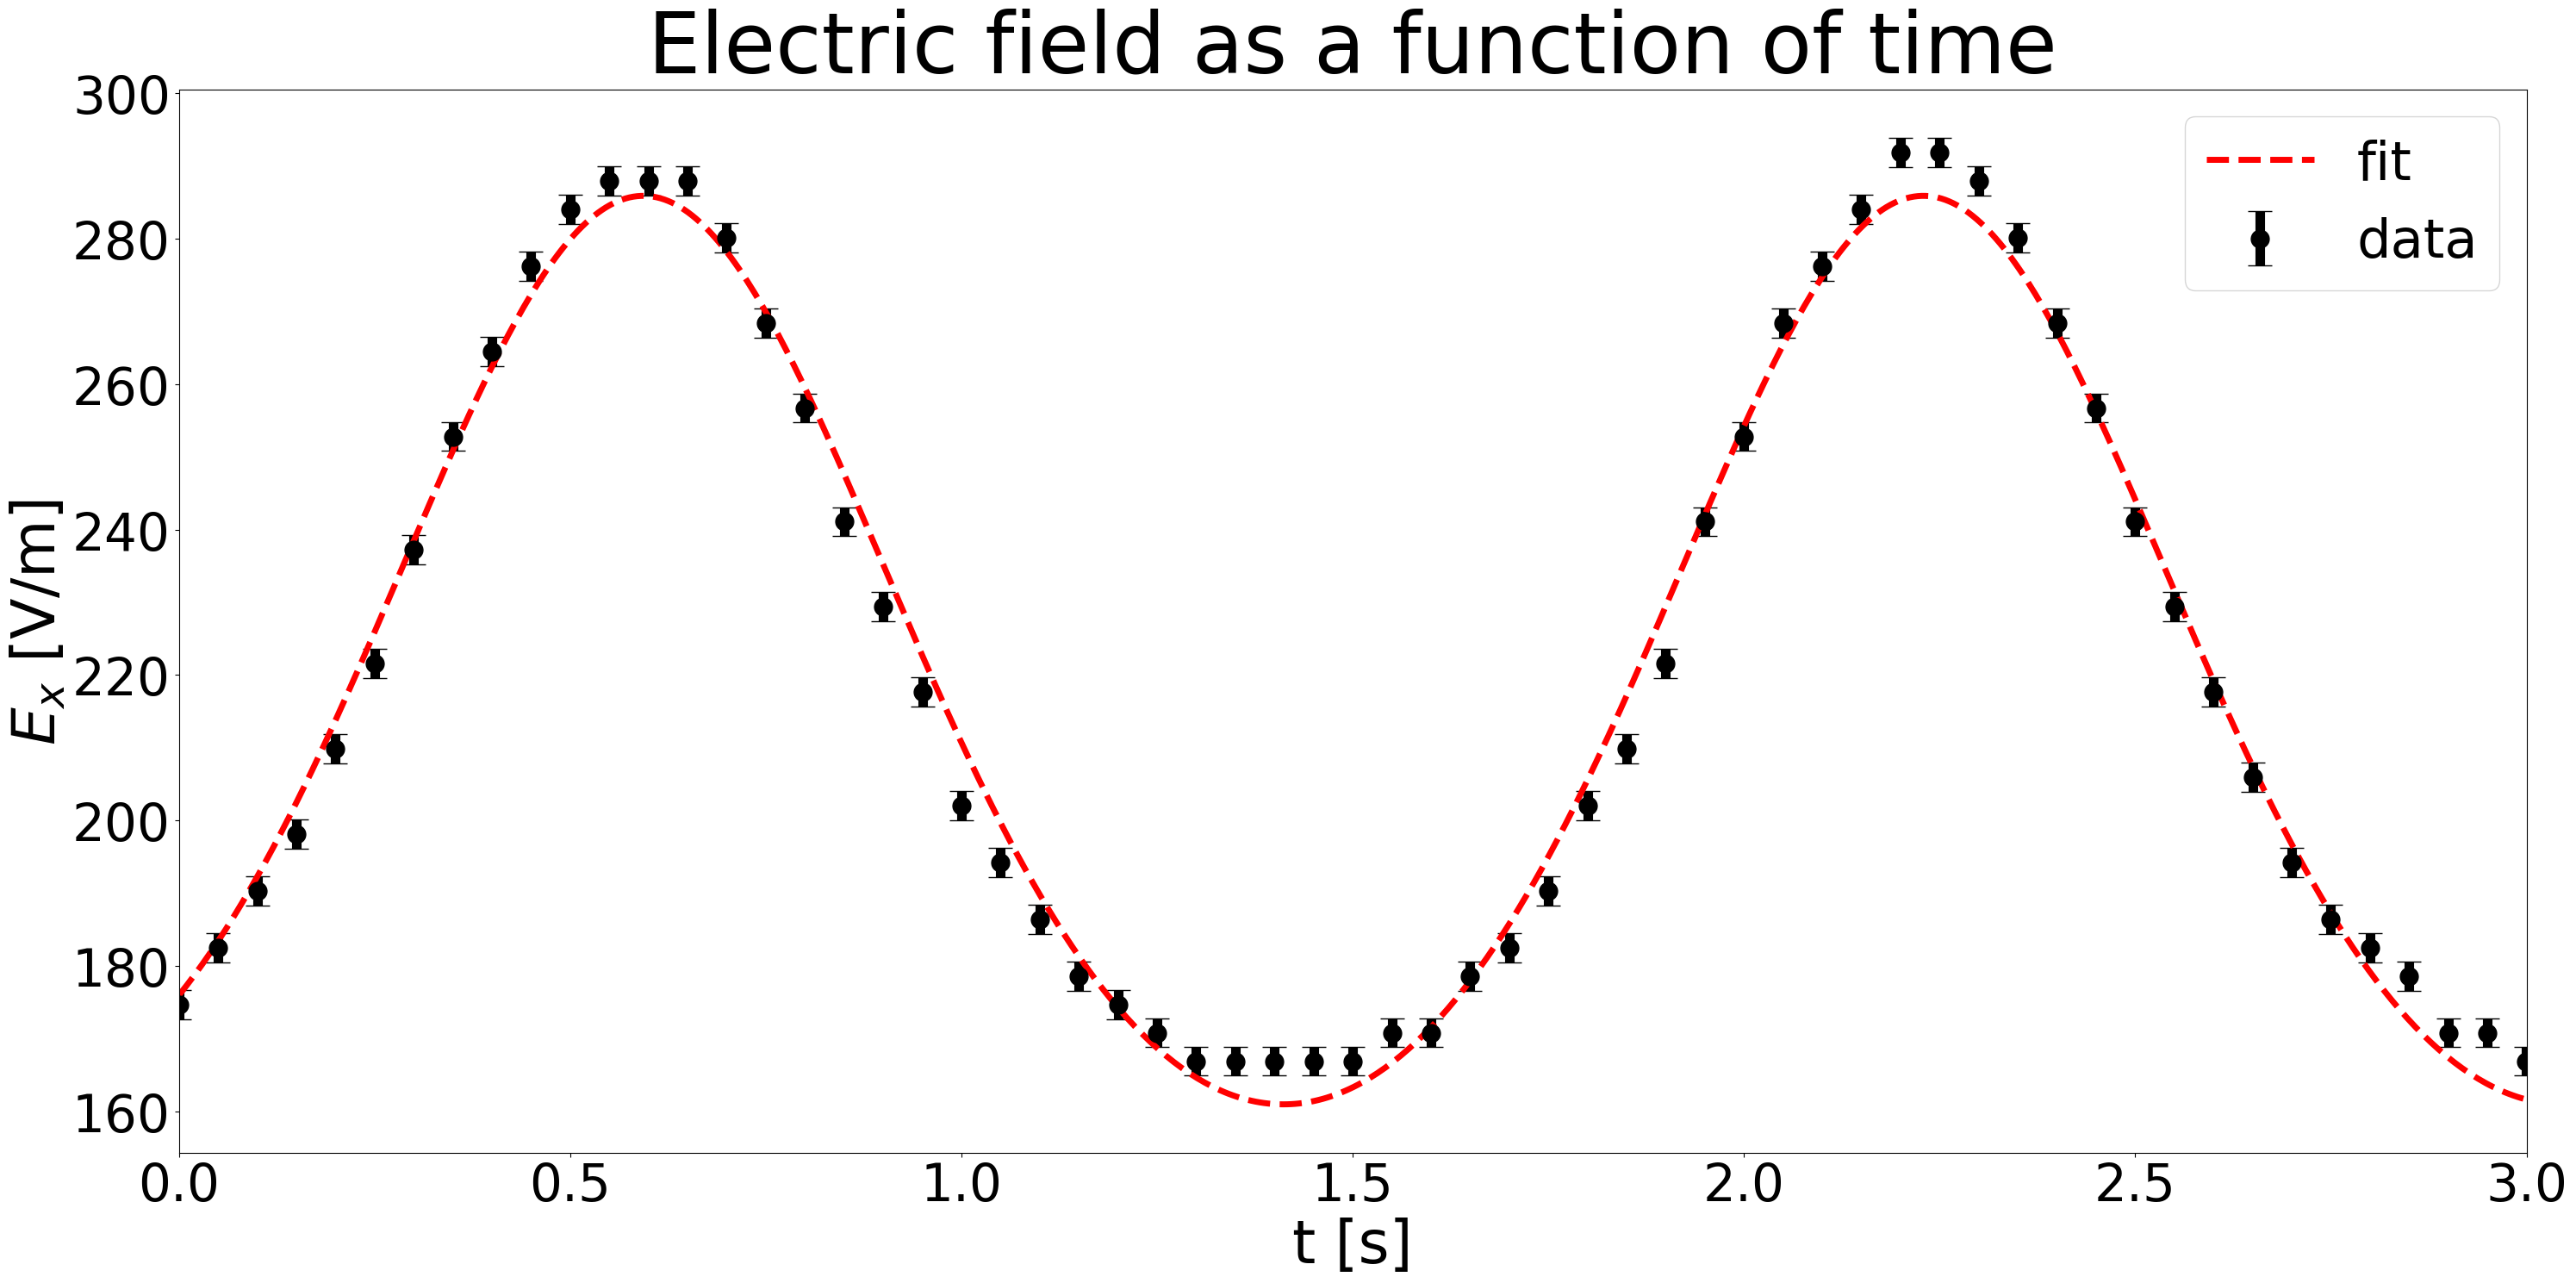

3259

3.8553386833890952 omega_inval
C_0 by fft -400.71875
1
[-1.3, 0.32608695652173914, -300, 3.8553386833890952, 4.725897920604916e-09]
beginvwd:  [-1.3, 0.32608695652173914, -300, 3.8553386833890952, 4.725897920604916e-09]
bounds:  [(-6.283185307179586, 6.283185307179586), (0, 2), (None, None), (2.891504012541821, 4.819173354236369), (1e-10, 0.01)]


c:\Users\samfa\anaconda3\Lib\site-packages\scipy\optimize\_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


[[-1.1773466184362498, -1.2064257017605182], [0.1077768393796025, 0.11084414586325192], [-287.7743638549542, -288.5345653805121], [0.5113081433392273, 8.036519215534916], [1.650701846170588e-05, 1.6582094263512172e-05]]
phi heeft als waarde: -1.1934 + -0.013024 - -0.016055 met 68% betrouwbaarheidsinterval: [-1.1773, -1.2064] 
A_norm heeft als waarde: 0.10926 + 0.0015857 - 0.0014816 met 68% betrouwbaarheidsinterval: [0.10778, 0.11084] 
C_0 heeft als waarde: -288.18 + -0.35454 - -0.40566 met 68% betrouwbaarheidsinterval: [-287.77, -288.53] 
omega heeft als waarde: 3.7992 + 4.2373 - 3.2879 met 68% betrouwbaarheidsinterval: [0.51131, 8.0365] 
q_norm heeft als waarde: 1.6544e-05 + 3.8494e-08 - 3.6582e-08 met 68% betrouwbaarheidsinterval: [1.6507e-05, 1.6582e-05] 
De p-waarde voor de hypothese test dat het model zinvol is, wordt gegeven door: 0.42573
De gereduceerde chi^2 waarde is: 1.0169
######################### Real data incoming ##############################
datapunt: phi = [-1.1934019

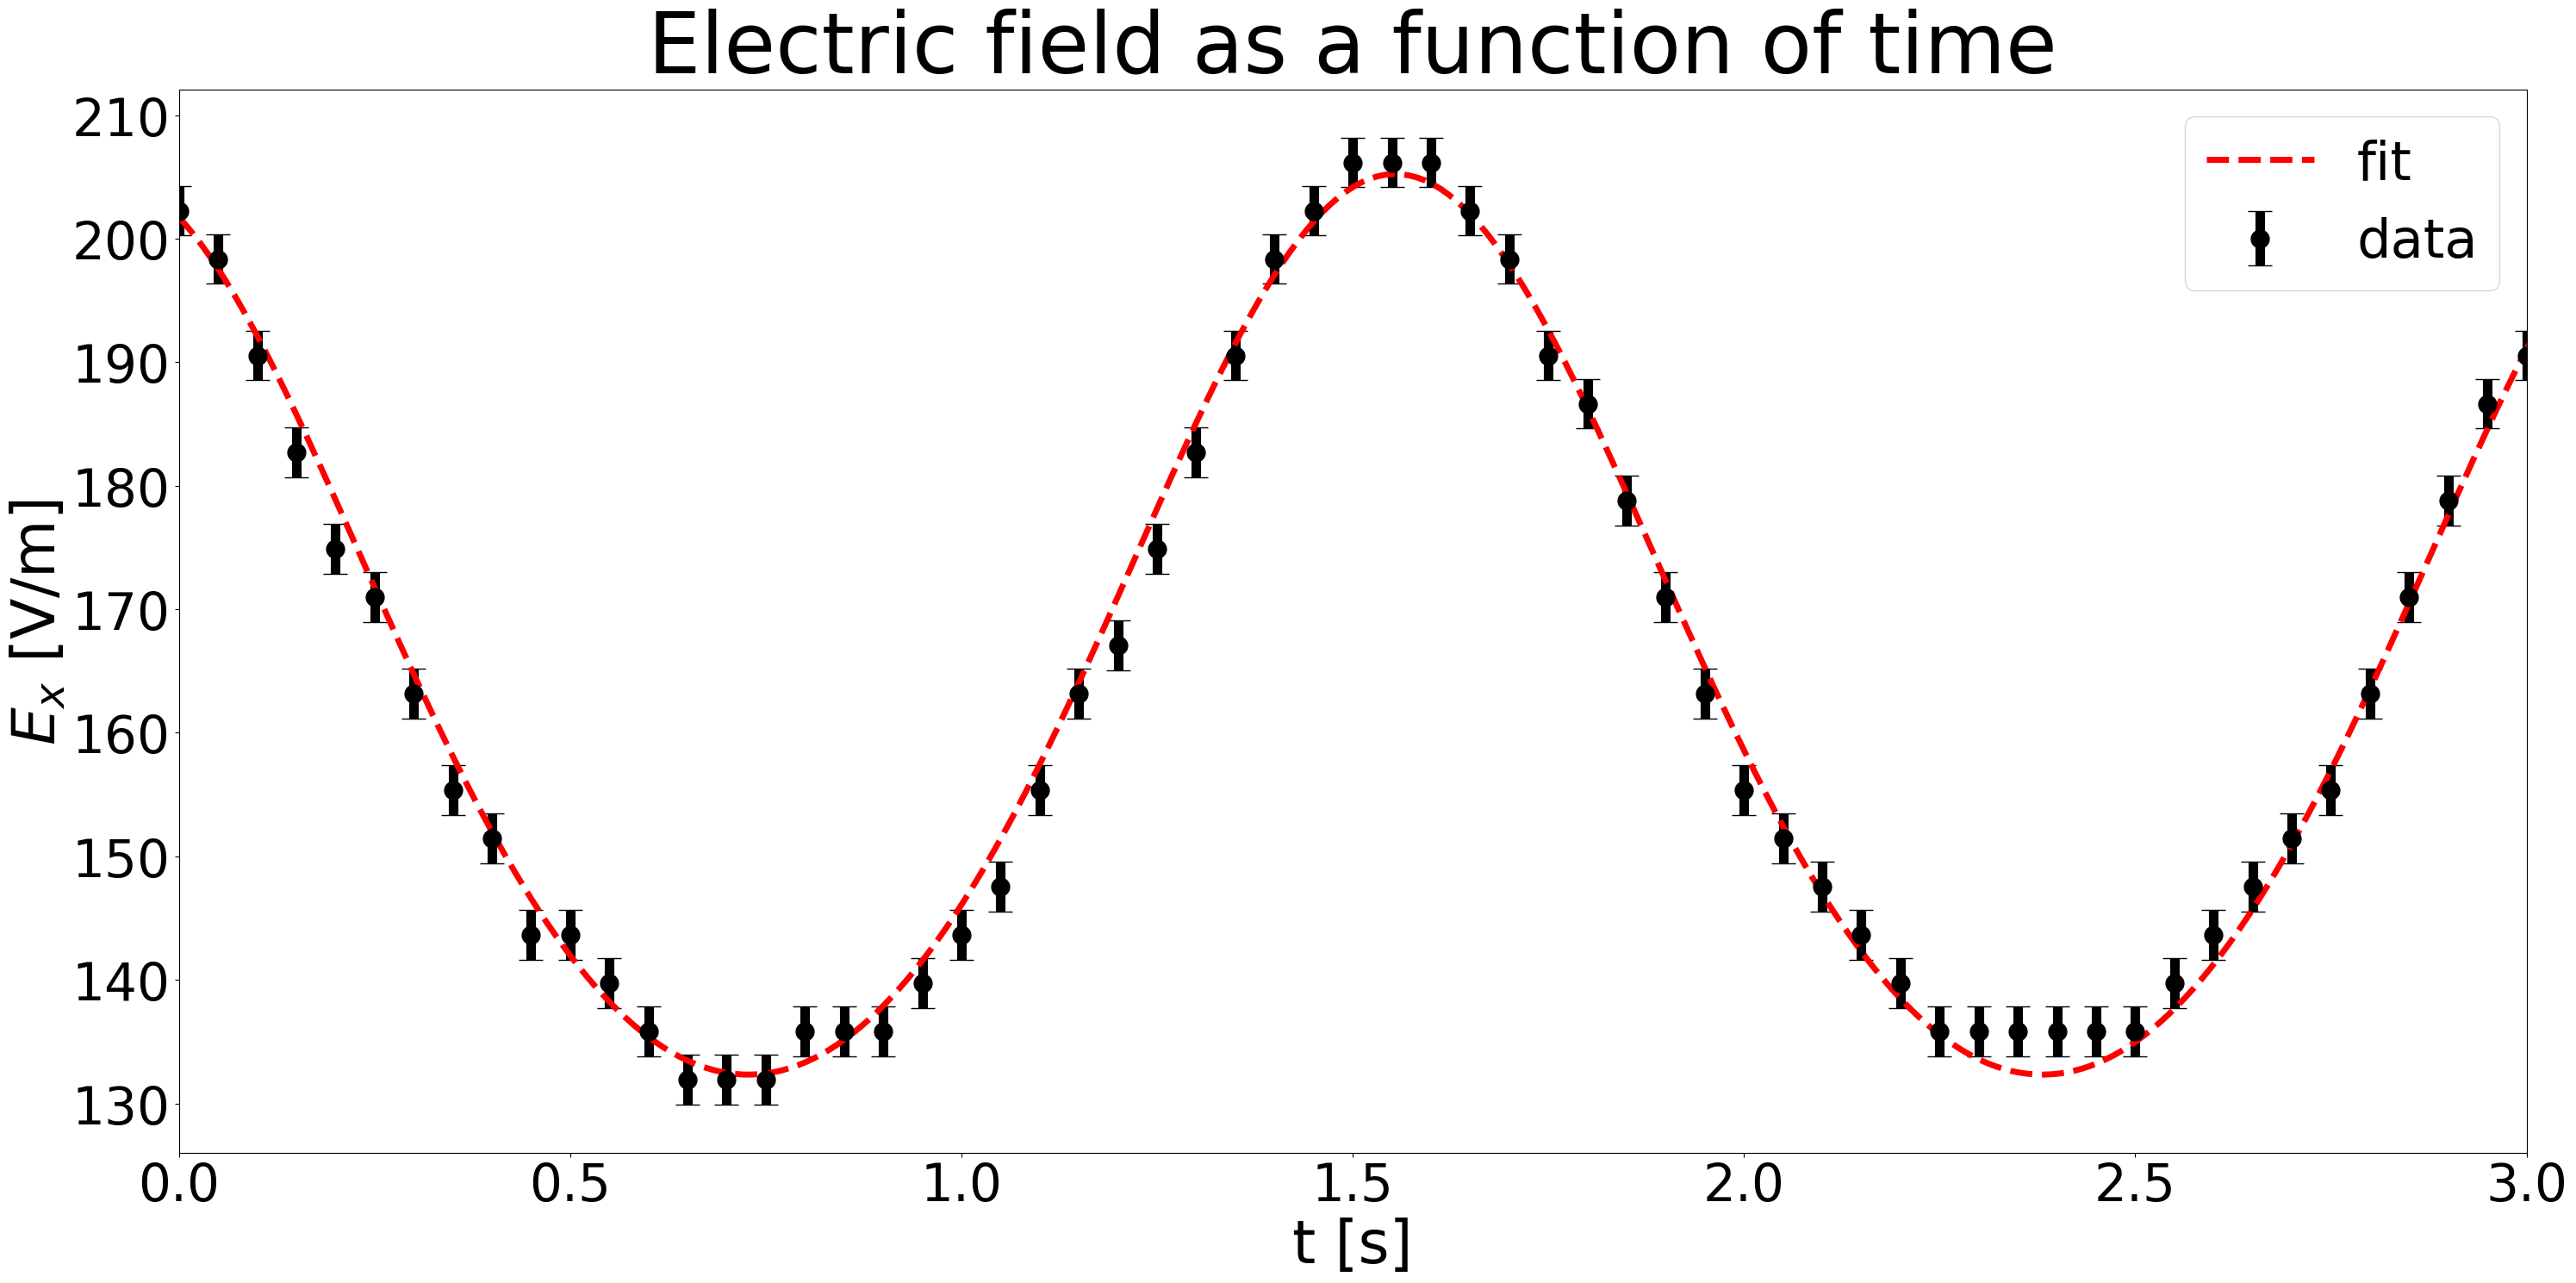

In [24]:
# parameters beginvoorwaarden: 'phi', 'A', 'C_0', 'omega', 'q'
#proef 3: OK
analyseer_data('Vrije proef/m3-1.txt', 0.57, 0.66, 1e-9, beginvoorwaarden = [.1, .15, -490, 4.028, 1e-9], minimizemethod = 'BFGS')#, constbounds = (-520, -300))
analyseer_data('Vrije proef/m3-2.txt', 0.57, 0.66, 1e-9, beginvoorwaarden = [0.1, .15, -350, 4 , 1e-9], knipvanaf = 5, detailed_logs = False, minimizemethod='TNC', titel = 'Electric field as a function of time')
analyseer_data('Vrije proef/m3-3.txt', 0.57, 0.66, 1e-9, minimizemethod='TNC')

2791

4.50206564160523 omega_inval
C_0 by fft 382.3515625
2788
[0.1, 0.32608695652173914, -490, 4.028, 4.725897920604916e-09]
beginvwd:  [0.1, 0.32608695652173914, -490, 4.028, 4.725897920604916e-09]
bounds:  [(-6.283185307179586, 6.283185307179586), (0, 2), (None, None), (3.3765492312039225, 5.627582052006538), (1e-10, 0.01)]
[[1.3333553912816978, 1.3438636285074539], [-0.1299495088569058, -0.13099857714770097], [-350.8861055416074, -351.7058271726423], [-0.7855565072772984, 19.97616268585323], [4.8942419533117766e-05, 4.902302648188791e-05]]
phi heeft als waarde: 1.3411 + 0.0027205 - 0.0077878 met 68% betrouwbaarheidsinterval: [1.3334, 1.3439] 
A_norm heeft als waarde: -0.13043 + -0.00056666 - -0.00048241 met 68% betrouwbaarheidsinterval: [-0.12995, -0.131] 
C_0 heeft als waarde: -351.32 + -0.38674 - -0.43298 met 68% betrouwbaarheidsinterval: [-350.89, -351.71] 
omega heeft als waarde: 3.8255 + 16.151 - 4.611 met 68% betrouwbaarheidsinterval: [-0.78556, 19.976] 
q_norm heeft als waarde: 4.

c:\Users\samfa\anaconda3\Lib\site-packages\scipy\optimize\_minimize.py:580: RuntimeWarning: Method BFGS cannot handle bounds.
  warn('Method %s cannot handle bounds.' % method,
c:\Users\samfa\anaconda3\Lib\site-packages\scipy\optimize\_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


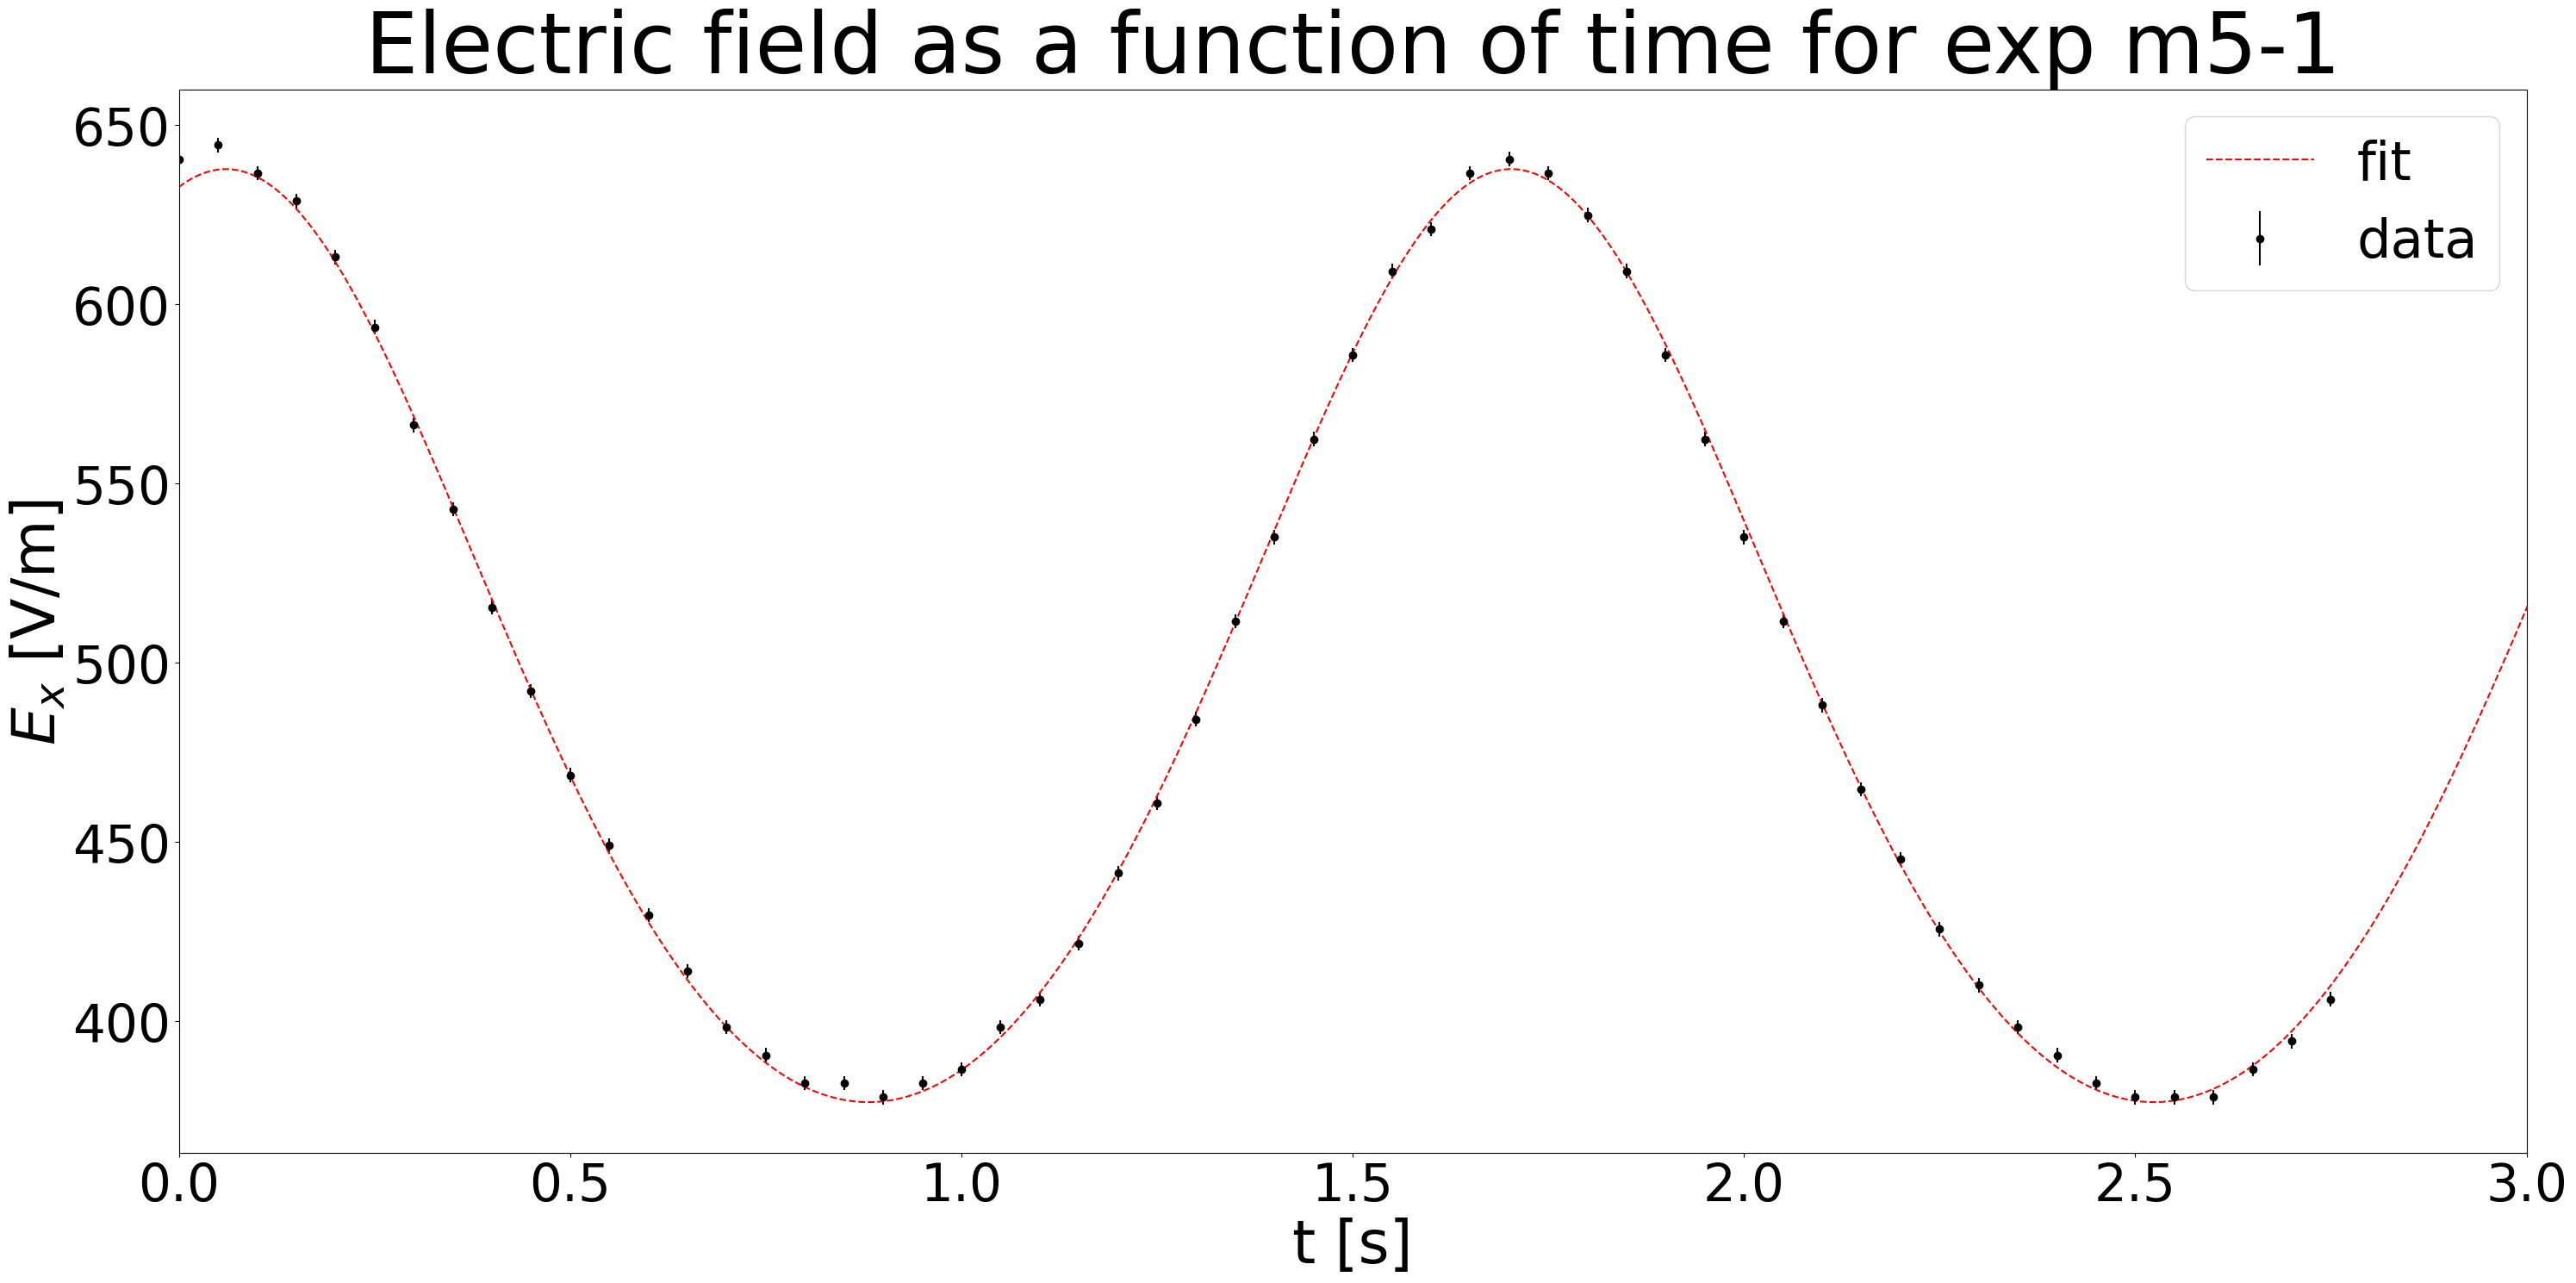

3107

4.043513323831146 omega_inval
C_0 by fft 856.3749999999998
1
[0.1, 0.32608695652173914, -500, 4, 4.725897920604916e-09]
beginvwd:  [0.1, 0.32608695652173914, -500, 4, 4.725897920604916e-09]
bounds:  [(-6.283185307179586, 6.283185307179586), (0, 2), (None, None), (3.0326349928733594, 5.054391654788932), (1e-10, 0.01)]
[[0.275757800077536, 0.2899249897135182], [0.21558043480198621, 0.21991748166977032], [94.24379551690059, 95.66690446079592], [1.3130132157746282, 8.34734280097657], [1.7035935315024485e-05, 1.718395311011002e-05]]
phi heeft als waarde: 0.28484 + 0.0050896 - 0.0090776 met 68% betrouwbaarheidsinterval: [0.27576, 0.28992] 
A_norm heeft als waarde: 0.21591 + 0.0040119 - 0.00032513 met 68% betrouwbaarheidsinterval: [0.21558, 0.21992] 
C_0 heeft als waarde: 94.359 + 1.3082 - 0.11487 met 68% betrouwbaarheidsinterval: [94.244, 95.667] 
omega heeft als waarde: 3.8188 + 4.5286 - 2.5058 met 68% betrouwbaarheidsinterval: [1.313, 8.3473] 
q_norm heeft als waarde: 1.7045e-05 + 1.3928e-

c:\Users\samfa\anaconda3\Lib\site-packages\scipy\optimize\_minimize.py:580: RuntimeWarning: Method BFGS cannot handle bounds.
  warn('Method %s cannot handle bounds.' % method,
c:\Users\samfa\anaconda3\Lib\site-packages\scipy\optimize\_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


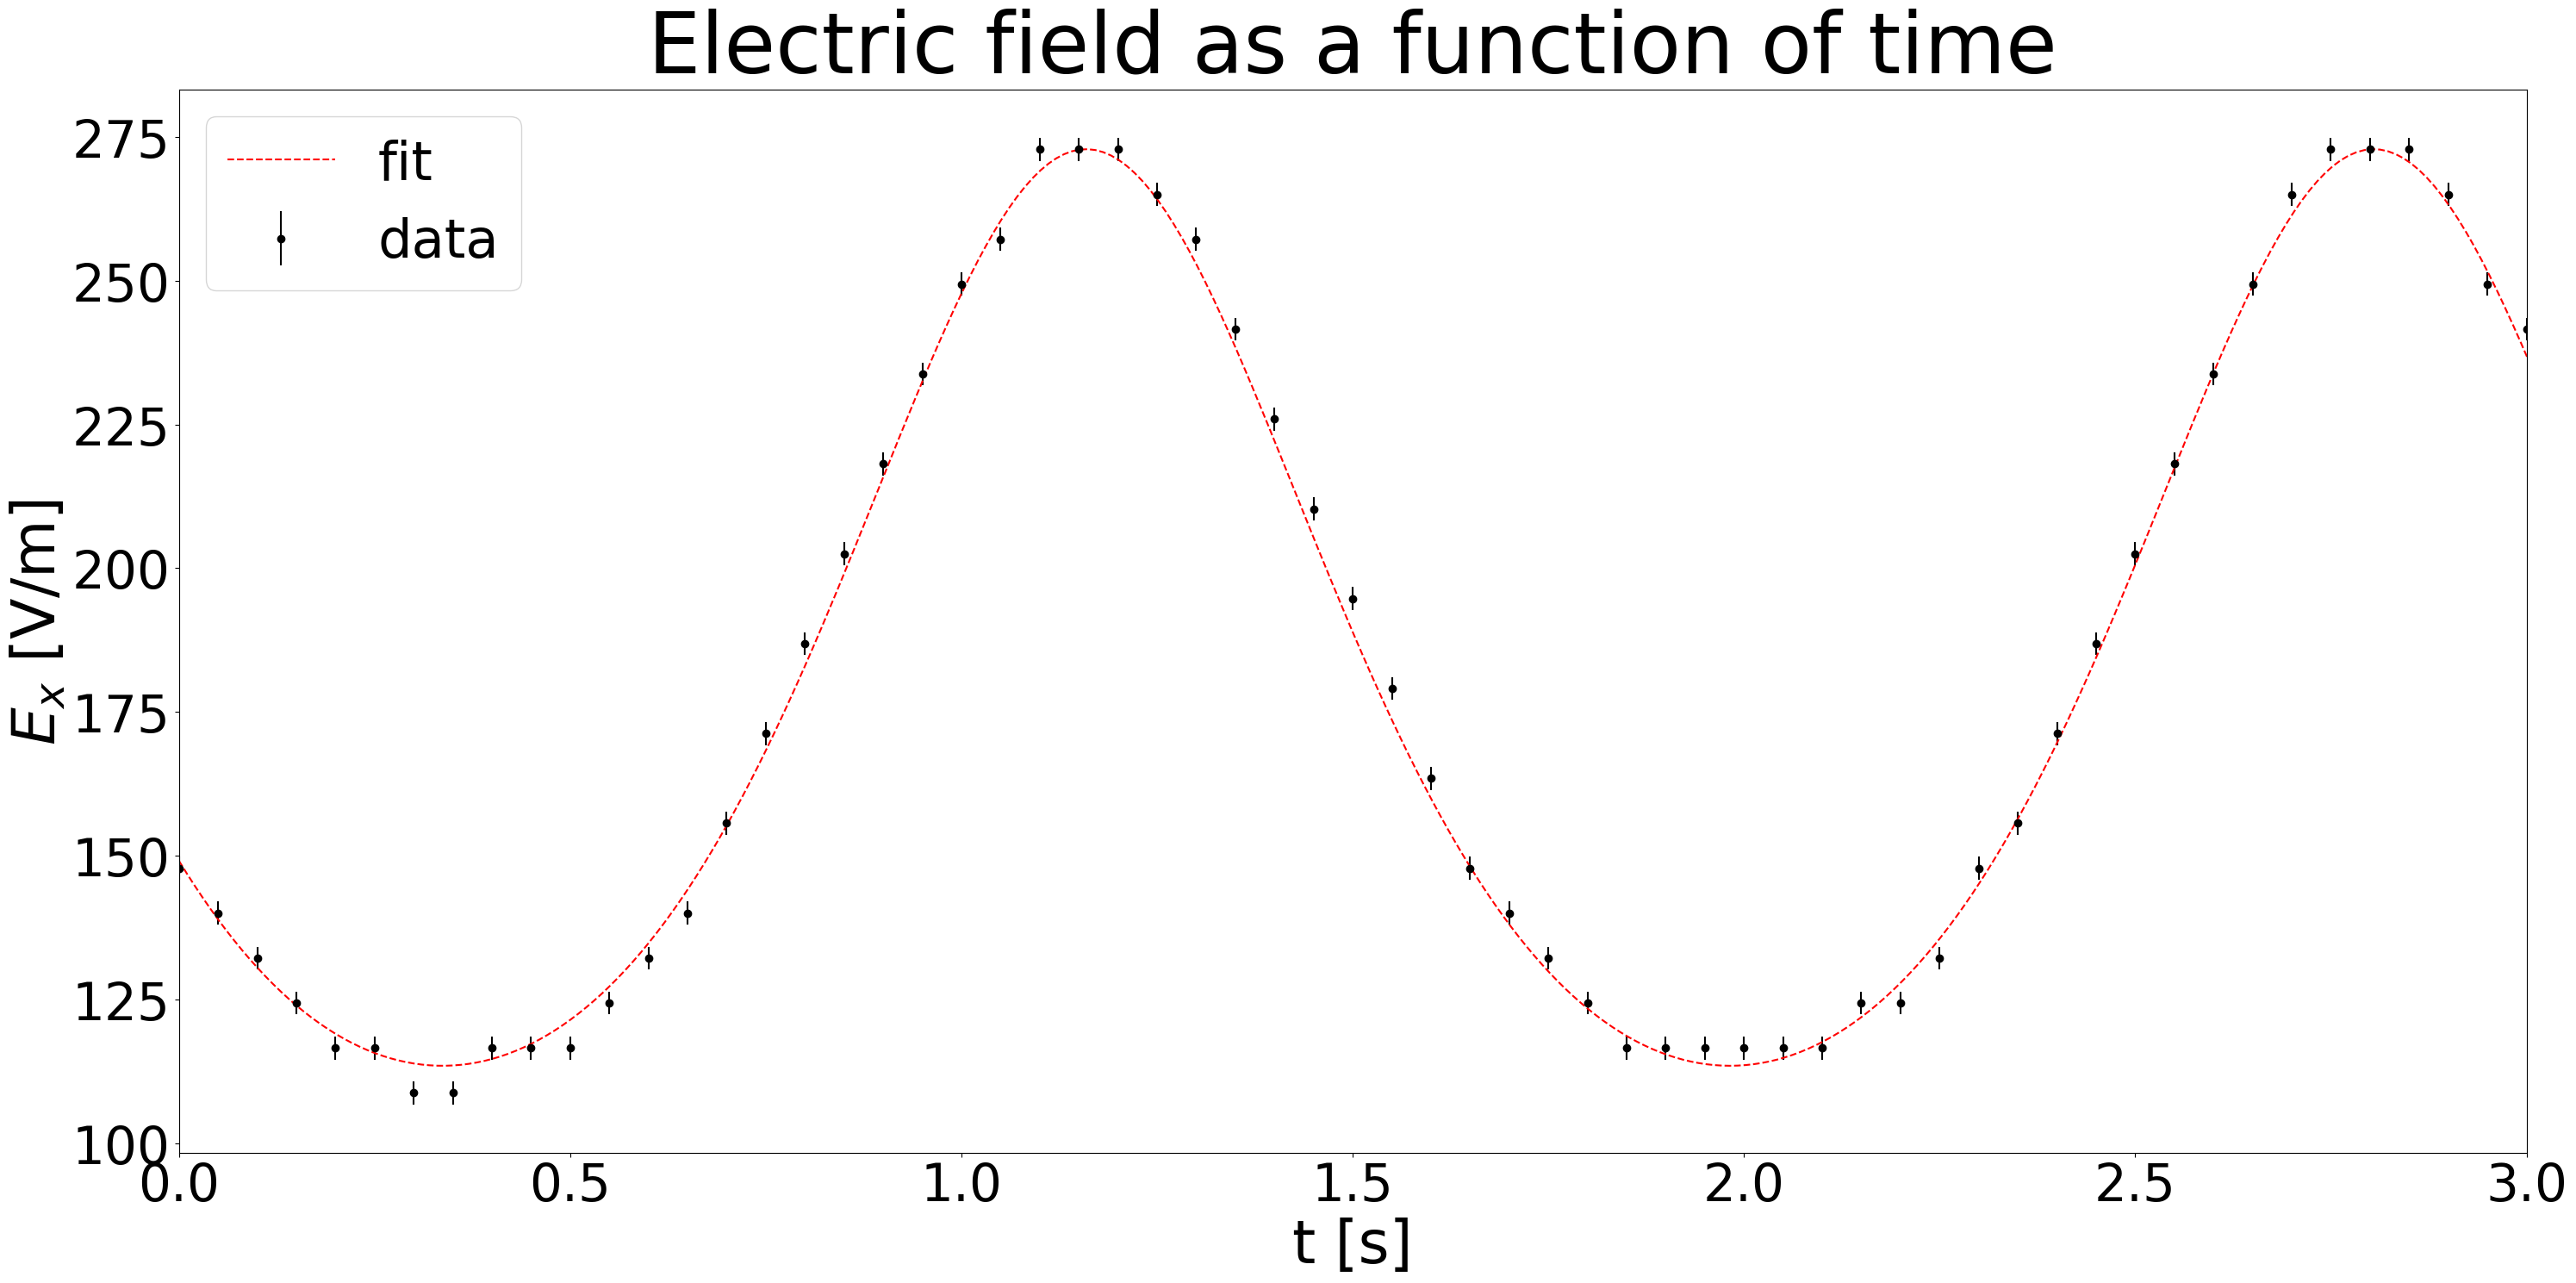

In [7]:
#proef 5: OK
analyseer_data('Vrije proef/m5-1.txt', 0.57, 0.484, 3e-9, beginvoorwaarden = [.1, .15, -490, 4.028, 1e-9], kniptot = 4, minimizemethod='BFGS', titel = 'Electric field as a function of time for exp m5-1')
analyseer_data('Vrije proef/m5-2.txt', 0.57, 0.60, 3e-9, beginvoorwaarden = [.1, .15, -500, 4, 1e-9], detailed_logs=False, minimizemethod = 'BFGS')

3259

3.8553386833890952 omega_inval
C_0 by fft 1201.781250000401
3256
[0.3, 0.33333333333333326, 250, 4.2, 4.9382716049382706e-09]
beginvwd:  [0.3, 0.33333333333333326, 250, 4.2, 4.9382716049382706e-09]
bounds:  [(-6.283185307179586, 6.283185307179586), (0, 2), (None, None), (2.891504012541821, 4.819173354236369), (1e-10, 0.01)]
[[2.043732613045496, 2.051394960593025], [0.25134641229575944, 0.25282556575715304], [109.20012251042499, 109.95860354429426], [3.8249806634012233, 16.045608348526734], [2.388388619432453e-05, 2.395142074310185e-05]]
phi heeft als waarde: 2.0476 + 0.0038323 - 0.0038301 met 68% betrouwbaarheidsinterval: [2.0437, 2.0514] 
A_norm heeft als waarde: 0.25209 + 0.00073878 - 0.00074037 met 68% betrouwbaarheidsinterval: [0.25135, 0.25283] 
C_0 heeft als waarde: 109.58 + 0.3792 - 0.37928 met 68% betrouwbaarheidsinterval: [109.2, 109.96] 
omega heeft als waarde: 3.8259 + 12.22 - 0.00091655 met 68% betrouwbaarheidsinterval: [3.825, 16.046] 
q_norm heeft als waarde: 2.391e-05 + 

c:\Users\samfa\anaconda3\Lib\site-packages\scipy\optimize\_minimize.py:580: RuntimeWarning: Method BFGS cannot handle bounds.
  warn('Method %s cannot handle bounds.' % method,
c:\Users\samfa\anaconda3\Lib\site-packages\scipy\optimize\_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


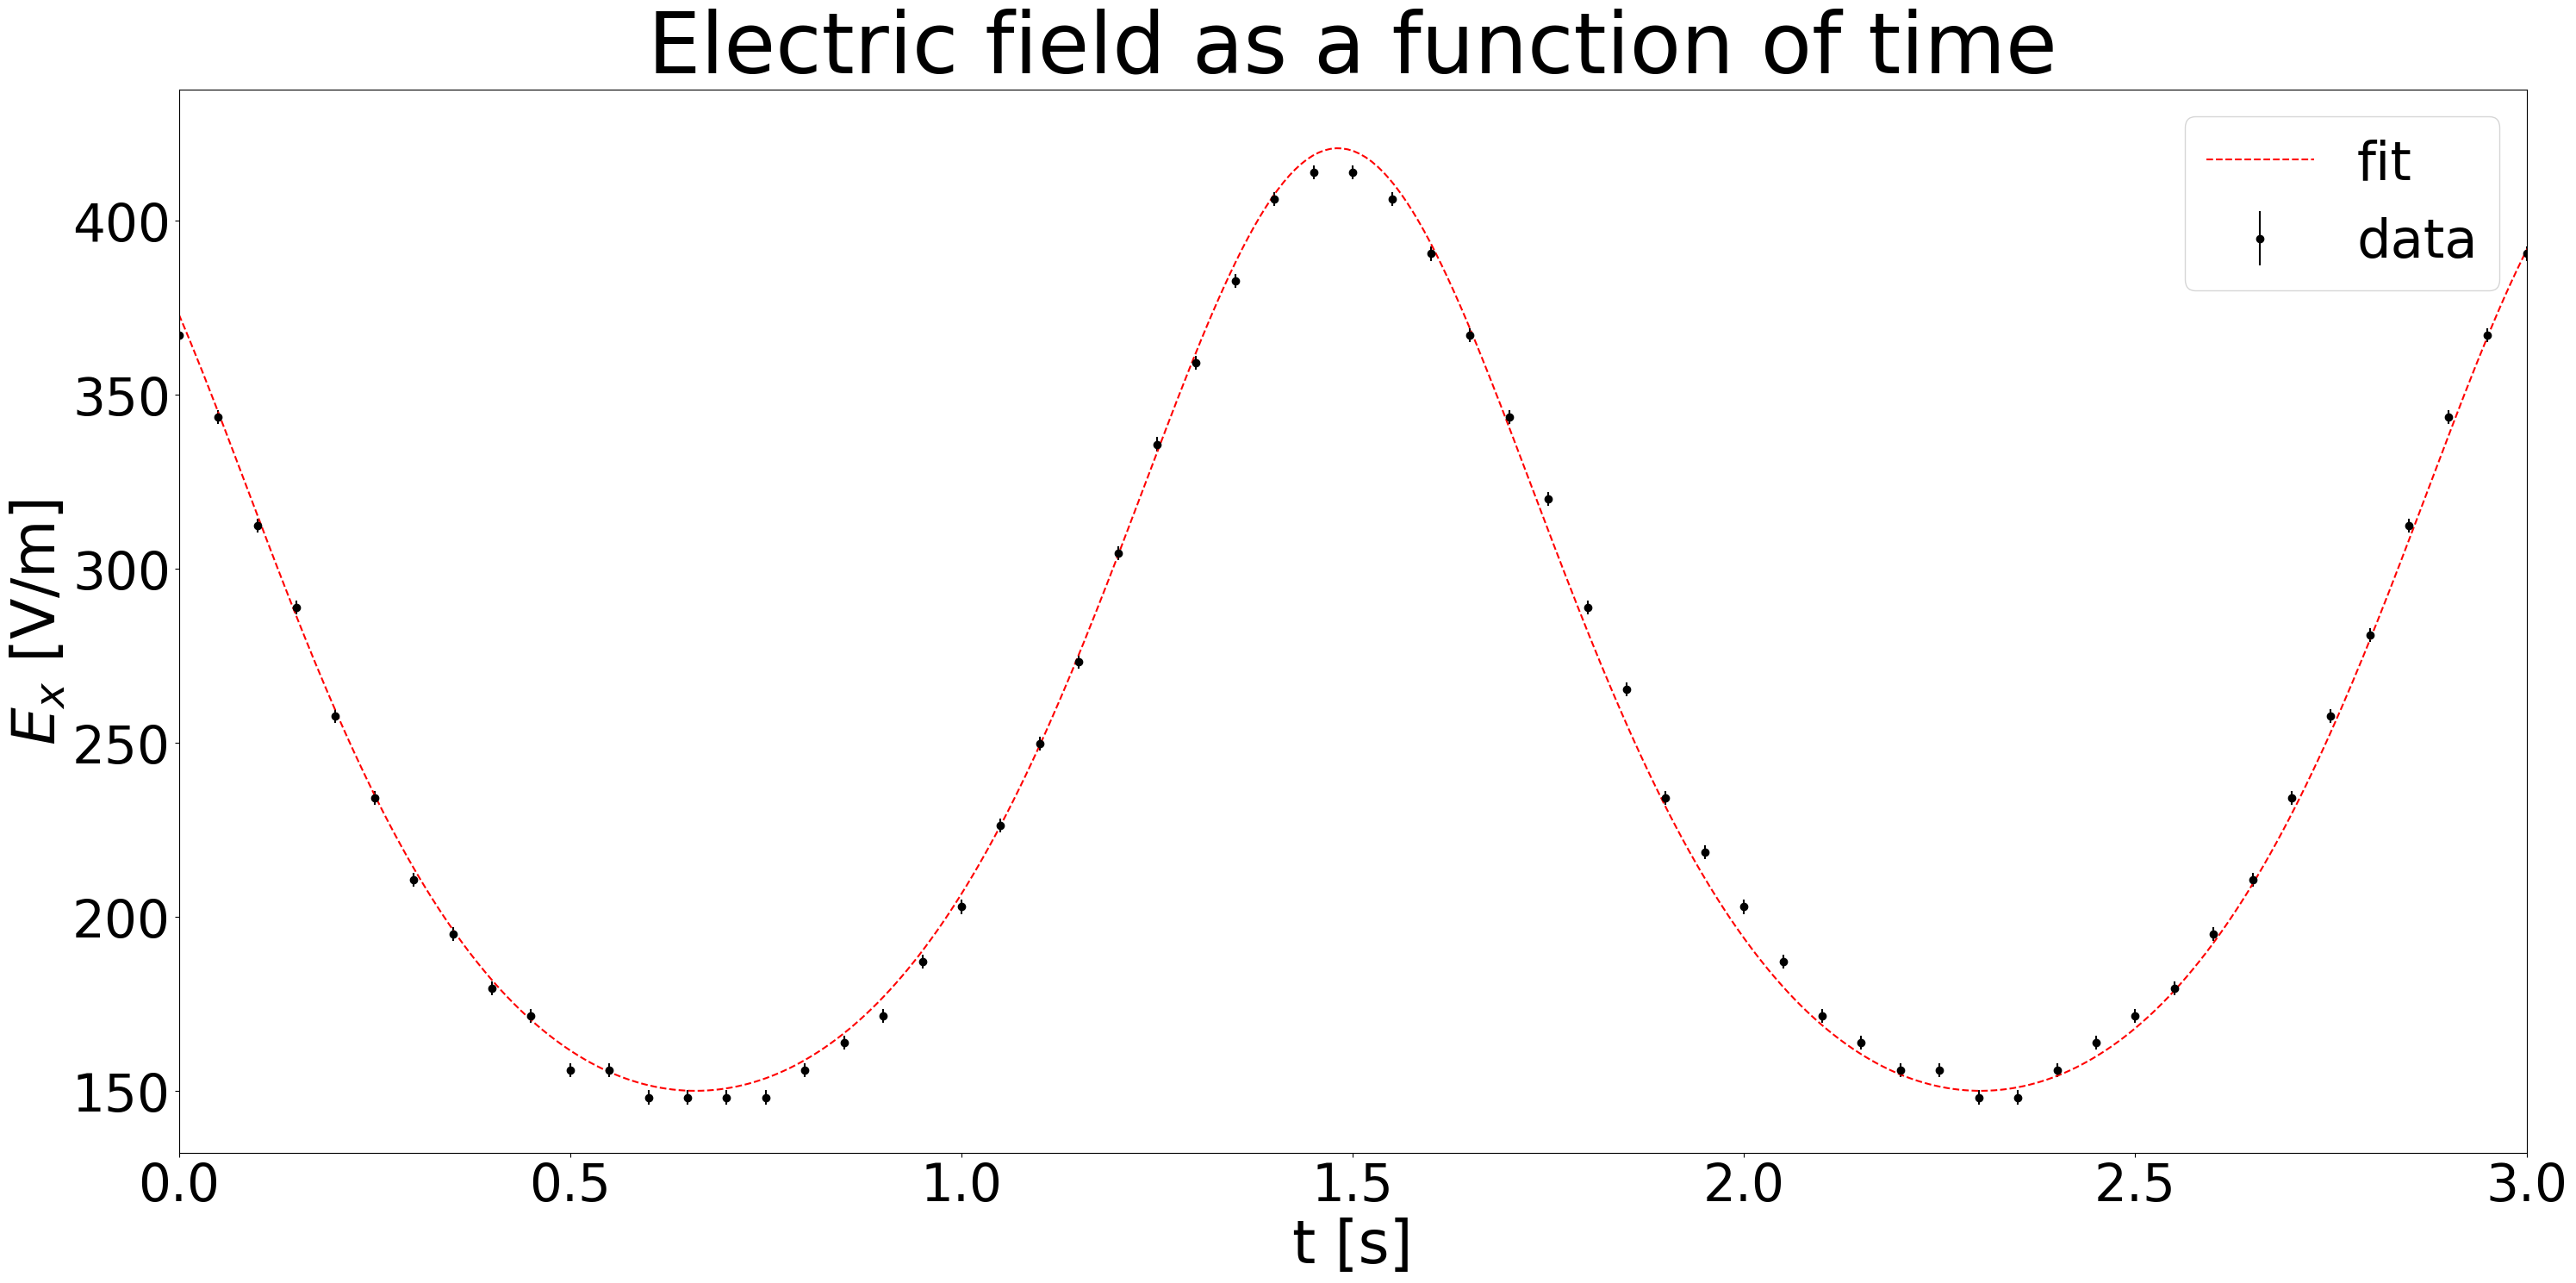

2825

4.447271726176805 omega_inval
C_0 by fft 1090.45312499988
1
[0, 0.33333333333333326, -400, 4.5, 4.9382716049382706e-09]
beginvwd:  [0, 0.33333333333333326, -400, 4.5, 4.9382716049382706e-09]
bounds:  [(-6.283185307179586, 6.283185307179586), (0, 2), (None, None), (3.3354537946326035, 5.559089657721006), (1e-10, 0.01)]
[[0.9265698392644617, 0.9330209339611055], [-0.29530747165984544, -0.2966827414713126], [110.39349710889135, 111.23573140346632], [2.374762424413704, 7.67635434988521], [2.4242627007239744e-05, 2.431476642661106e-05]]
phi heeft als waarde: 0.92972 + 0.0033049 - 0.0031462 met 68% betrouwbaarheidsinterval: [0.92657, 0.93302] 
A_norm heeft als waarde: -0.29579 + -0.00088921 - -0.00048606 met 68% betrouwbaarheidsinterval: [-0.29531, -0.29668] 
C_0 heeft als waarde: 110.7 + 0.53178 - 0.31045 met 68% betrouwbaarheidsinterval: [110.39, 111.24] 
omega heeft als waarde: 4.4787 + 3.1976 - 2.1039 met 68% betrouwbaarheidsinterval: [2.3748, 7.6764] 
q_norm heeft als waarde: 2.4264e-05

c:\Users\samfa\anaconda3\Lib\site-packages\scipy\optimize\_minimize.py:580: RuntimeWarning: Method BFGS cannot handle bounds.
  warn('Method %s cannot handle bounds.' % method,
c:\Users\samfa\anaconda3\Lib\site-packages\scipy\optimize\_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


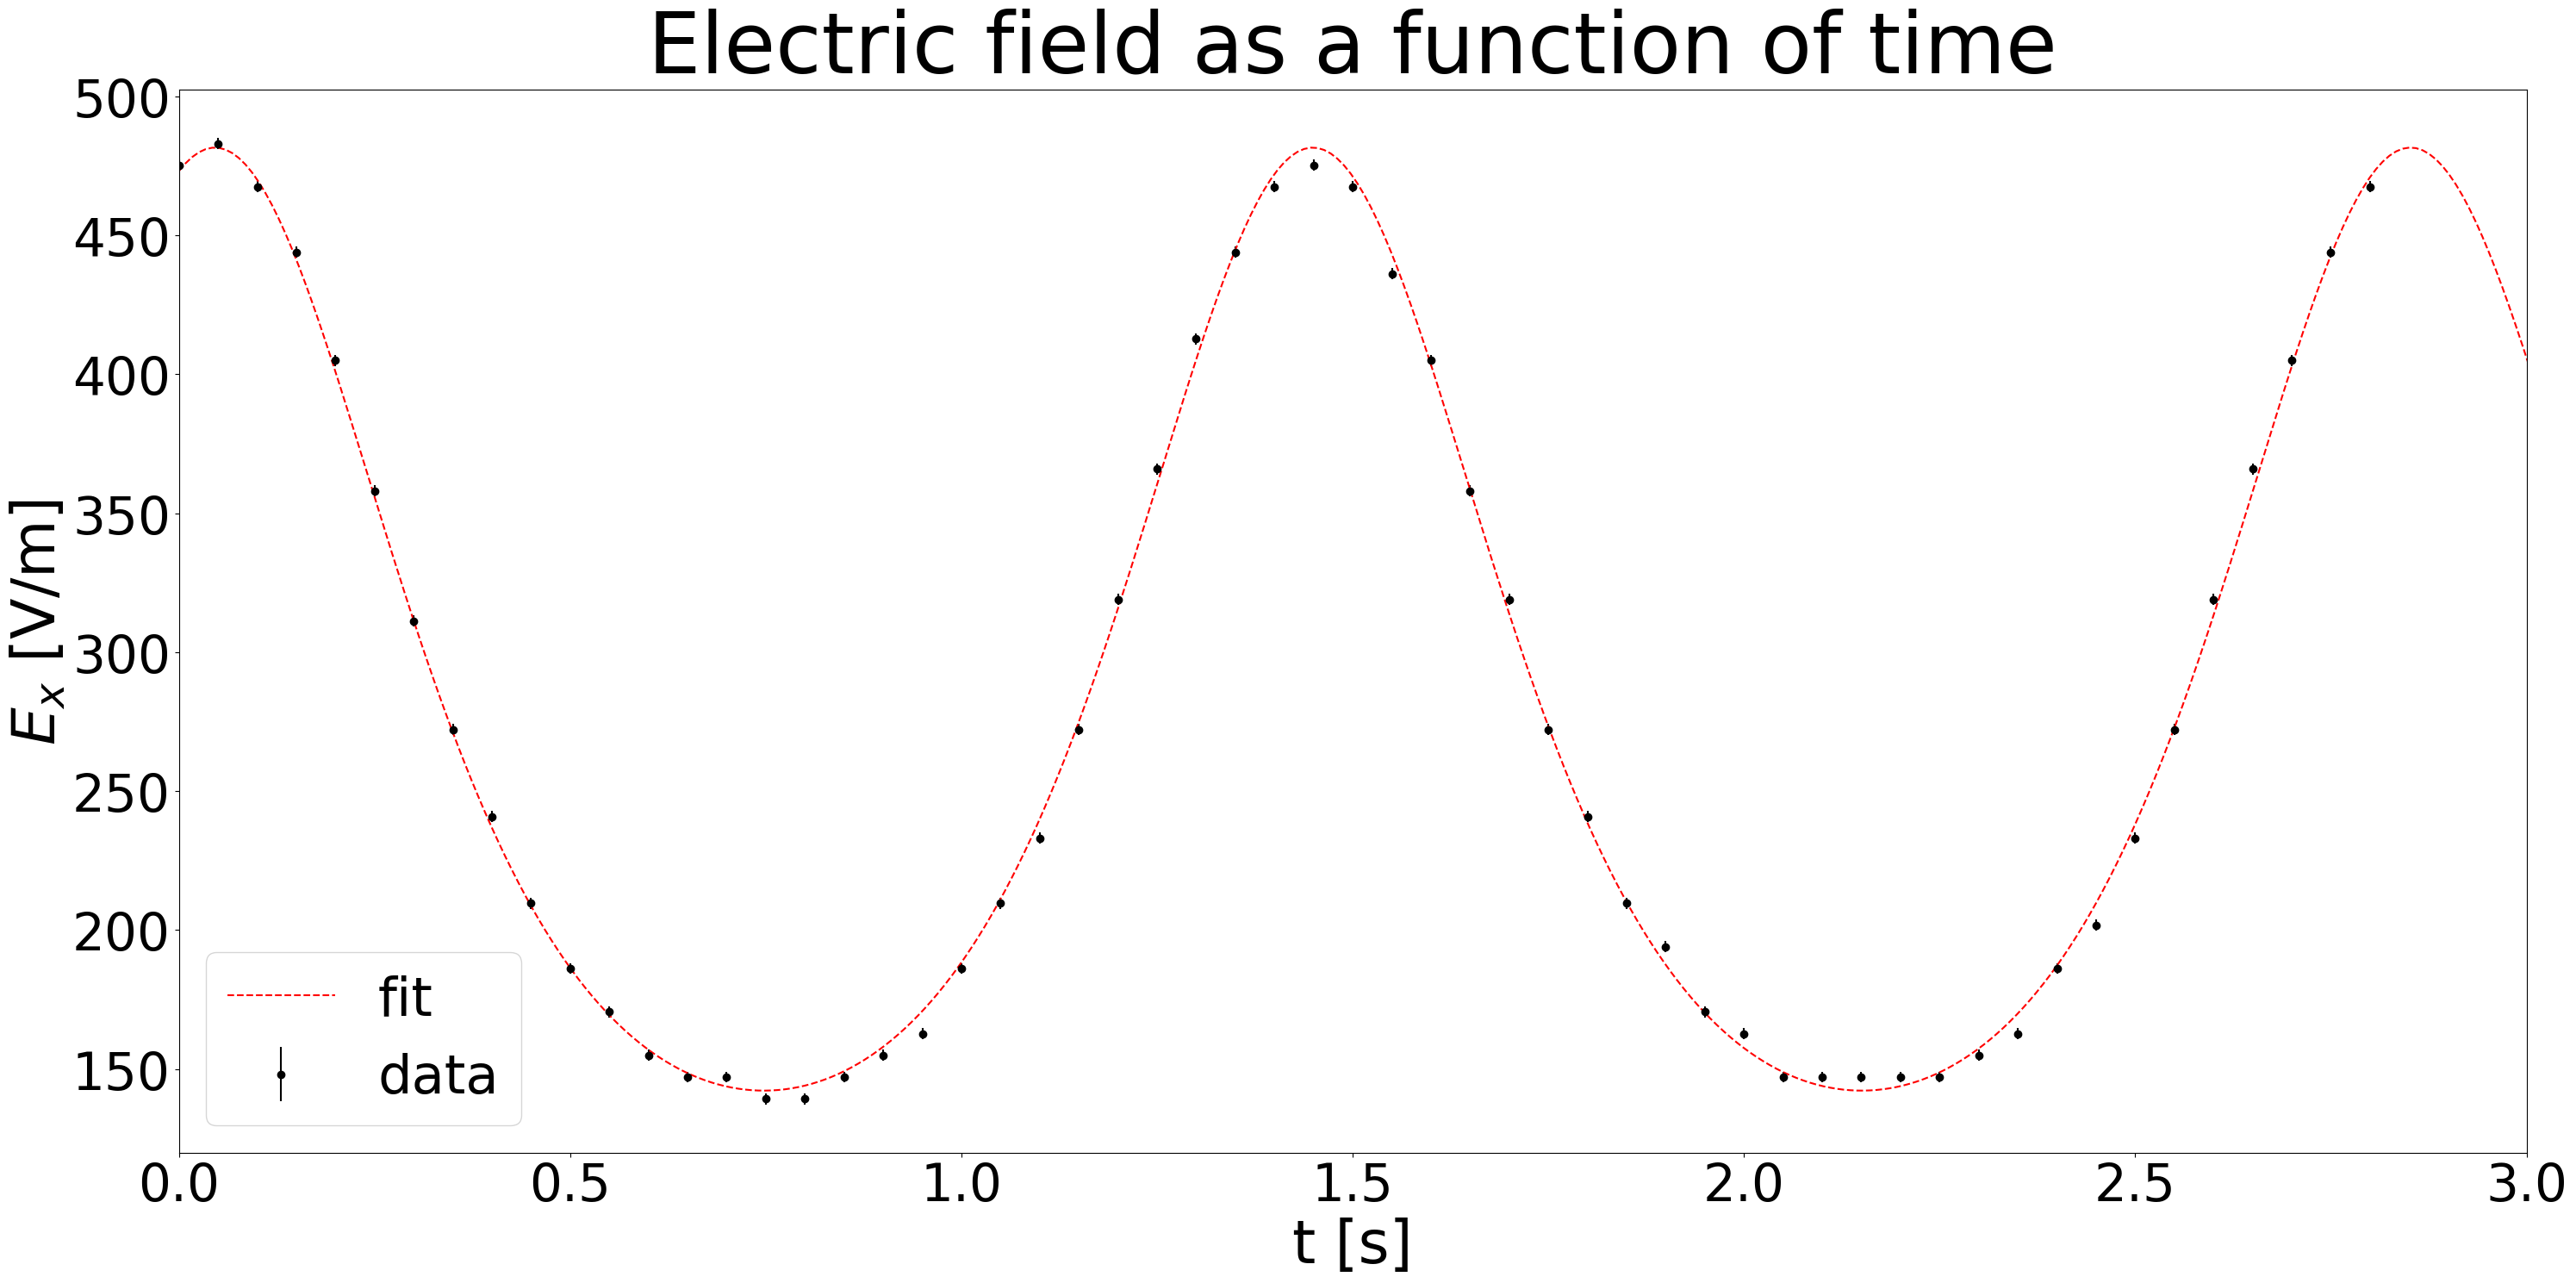

2486

5.054391654788932 omega_inval
C_0 by fft 954.71875
1
[0, 0.33333333333333326, -200, 5.5, 4.9382716049382706e-09]
beginvwd:  [0, 0.33333333333333326, -200, 5.5, 4.9382716049382706e-09]
bounds:  [(-6.283185307179586, 6.283185307179586), (0, 2), (None, None), (3.790793741091699, 6.3179895684861656), (1e-10, 0.01)]
[[-0.40562505451228703, -0.41394270761706936], [0.24604909425135757, 0.24858815022531816], [106.7298888777348, 107.60151224257872], [1.9444644940172033, 10.804391560847929], [2.5566503060553198e-05, 2.565429346228888e-05]]
phi heeft als waarde: -0.41001 + -0.0039331 - -0.0043845 met 68% betrouwbaarheidsinterval: [-0.40563, -0.41394] 
A_norm heeft als waarde: 0.24633 + 0.0022537 - 0.00028538 met 68% betrouwbaarheidsinterval: [0.24605, 0.24859] 
C_0 heeft als waarde: 107.12 + 0.48466 - 0.38696 met 68% betrouwbaarheidsinterval: [106.73, 107.6] 
omega heeft als waarde: 5.0957 + 5.7087 - 3.1513 met 68% betrouwbaarheidsinterval: [1.9445, 10.804] 
q_norm heeft als waarde: 2.5588e-05 + 

c:\Users\samfa\anaconda3\Lib\site-packages\scipy\optimize\_minimize.py:580: RuntimeWarning: Method BFGS cannot handle bounds.
  warn('Method %s cannot handle bounds.' % method,
c:\Users\samfa\anaconda3\Lib\site-packages\scipy\optimize\_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
c:\Users\samfa\anaconda3\Lib\site-packages\scipy\optimize\_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


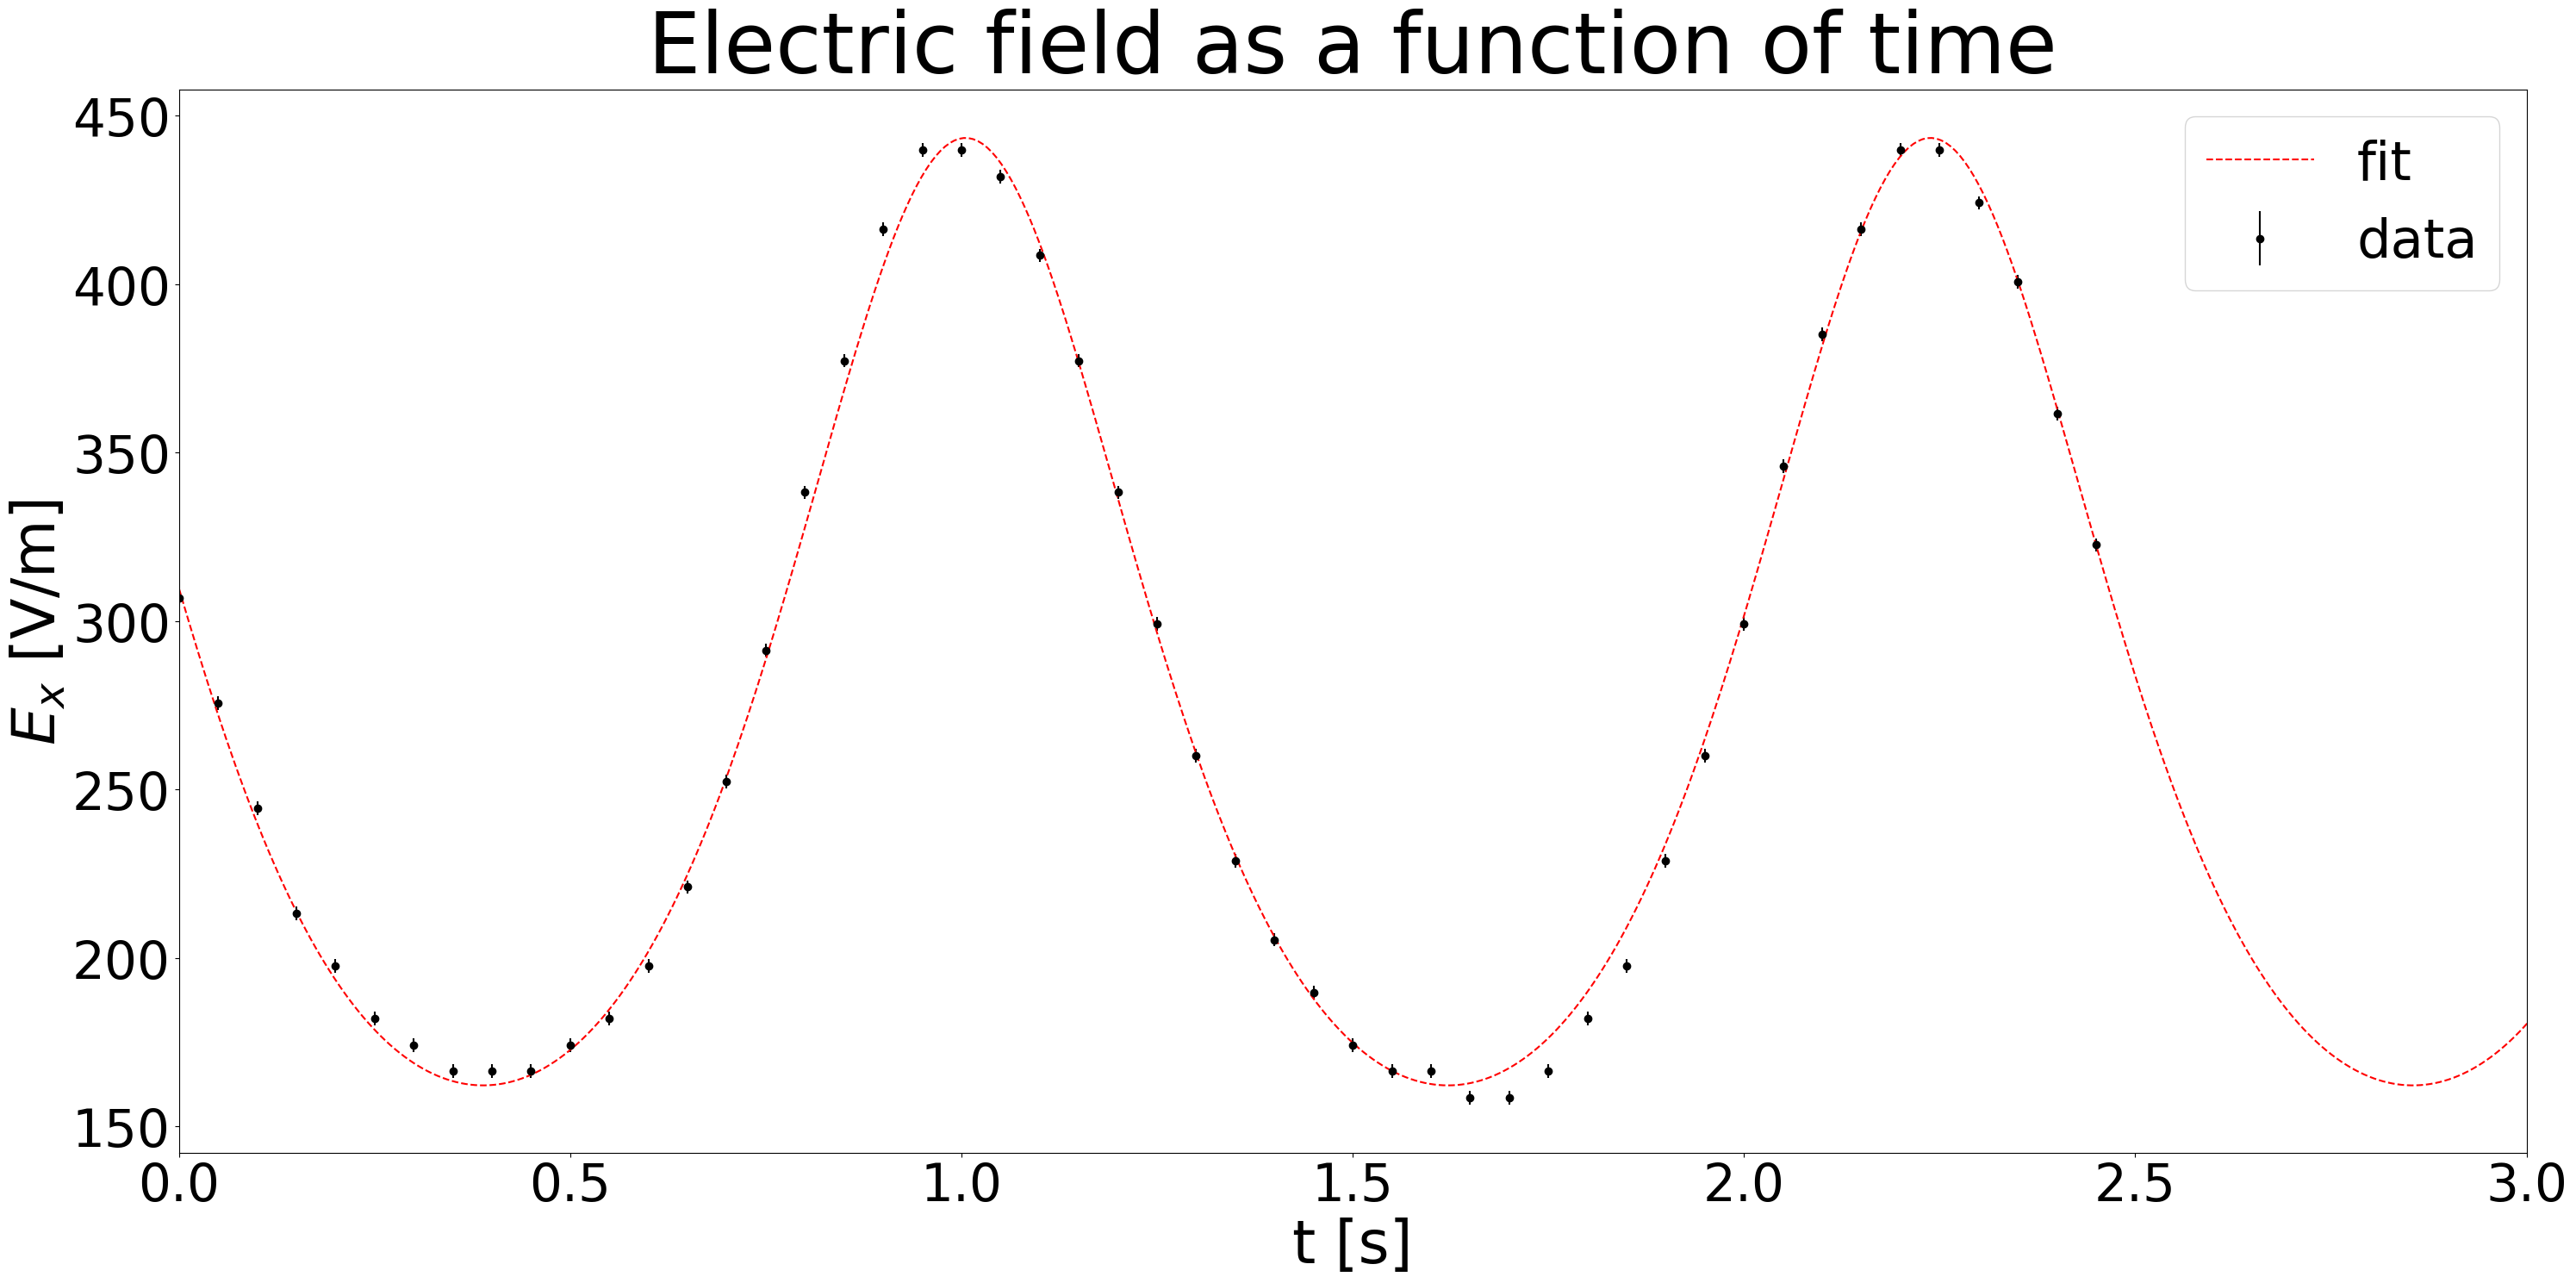

In [8]:
#proef 6: OK
analyseer_data('Vrije proef/m6-1.txt', 0.56, 0.66, 3e-9, knipvanaf = 2.5, beginvoorwaarden = [0.3, .15, 250, 4.2, 1e-9], detailed_logs=False, minimizemethod='BFGS') #iets vaag met de amplitude (windstoot ofzo idk) maar voor de rest ok
analyseer_data('Vrije proef/m6-2.txt', 0.56, 0.496, 3e-9, knipvanaf = 1.5, detailed_logs = False, beginvoorwaarden = [0, .15, -400, 4.5, 1e-9], minimizemethod='BFGS') #idem
analyseer_data('Vrije proef/m6-3.txt', 0.56, 0.384, 3e-9, beginvoorwaarden = [0, .15, -200, 5.5, 1e-9], kniptot = 6, detailed_logs=False, minimizemethod='BFGS')

In [9]:
print(fitparamdict)
nieuwdict = dict()
for key in fitparamdict.keys():
    nieuwdict[key] = [functies.datapunt_to_vector(fitparamdict[key][i]) for i in range(5)]
print('fitparamdict = ' + str(nieuwdict))
chiredlijst = np.array(chiredlijst)
print(chiredlijst)
print('chired mean:', np.mean(chiredlijst))
print('chired sigma:', np.sqrt(np.var(chiredlijst)))
print('max:',max(chiredlijst))
print('min:',min(chiredlijst))

{'m1-1': [datapunt: phi = [-1.0552772080016823, 0.005531726674375732, 'S'], datapunt: A_norm*x0 = [0.10884734143241305, 0.0006399563392273904, 'Normaal'], datapunt: C_0 = [-524.310061769978, -0.34, 'S'], datapunt: omega = [3.8092380839087596, 1.9000001077894706, 'S'], datapunt: q_norm*x0*x0 = [8.220745460579905e-09, 5.7808095178043315e-11, 'Normaal']], 'm1-2': [datapunt: phi = [-0.054588477442186034, 0.00560357029044876, 'S'], datapunt: A_norm*x0 = [-0.09523052240143468, -0.0005320039139401581, 'Normaal'], datapunt: C_0 = [-489.51928836695566, 0.49203658400570177, 'S'], datapunt: omega = [3.817307189153929, 1.8000011111107683, 'S'], datapunt: q_norm*x0*x0 = [6.0503901372661276e-09, 4.2168689548301245e-11, 'Normaal']], 'm1-3': [datapunt: phi = [-3.1919169207422864, 0.011115754585272202, 'S'], datapunt: A_norm*x0 = [0.056122892315337757, 0.00034808847426847554, 'Normaal'], datapunt: C_0 = [-584.5575069241455, 1.20359835493407, 'S'], datapunt: omega = [3.8169810423867077, 1.80000027777775